<a href="https://colab.research.google.com/github/rebcervasio/Machine_Learning_Materials_Science_PhD/blob/main/Machine_Learning_Semiconductors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  High-thoughput ab initio calculation using Python



---------------------------------

### Used Libraries


In [ ]:
!pip install pymatgen  # open-source librarie for materials analysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 42.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 KB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.1/515.1 KB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.2/236.2 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.3/555.3 KB 42.4 MB/s eta 0:00:0

In [ ]:
!pip install mp_api # api for connecting to materialsproject.org database

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pymatgen.ext.matproj  import MPRester                         # API connetion with Materials Project
from pymatgen.core.periodic_table import Element                   # chemical elements
from pymatgen.core.structure import Structure                      # crystal structures
from pymatgen.core.composition import Composition                  # compounds
from pymatgen.electronic_structure.plotter import BSPlotter        # band structure
from pymatgen.io import vasp                                       # VASP interface

import pandas as pd   
import numpy as np    
import os             

import matplotlib.pyplot as plt 
import seaborn as sns           

# Project 1 - Ultrawide Bandgap (UWBG Semiconductors)

---------------------------
# Section 1 - Screening 

Screnning materials: automized search and collection of data for the analysis of ultra-large band gap semiconductors

**Search Criteria:**
* Ternary materials
* Non-radioactive materials
* Direct bandgap between 4 and 12 eV
* Reported band structure
* Thermodynamically stable
* Known fabrication

#### Non-radioactive elements

In [ ]:
# Generates the non-radioactive elements desired

def desired_element(elem):
    omit = ['Po', 'At', 'Rn', 'Fr', 'Ra'] # radiactive elements
    return not elem.is_noble_gas and not elem.is_actinoid and not elem.symbol in omit

element_universe = [e for e in Element if desired_element(e)]
omitted_elements = [e for e in Element if e not in element_universe]
elements = [e.symbol for e in element_universe] 

print("Number of selected elements:", len(elements))
print("Elements not included:", " ".join(sorted([e.symbol for e in omitted_elements])))

Number of selected elements: 92
Elements not included: Ac Am Ar At Bk Cf Cm Es Fm Fr He Kr Lr Md Ne No Np Og Pa Po Pu Ra Rn Th U Xe


#### Database - Materials Project
Public materials database! 

Properties: https://workshop.materialsproject.org/lessons/04_materials_api/MAPI%20Lesson%20%28filled%29/.

Sintax (uses MongoDB) https://www.mongodb.com/docs/manual/reference/operator/query/

Available properties in: https://github.com/materialsproject/mapidoc/tree/master/materials


In [ ]:
# Criteria for search:
criteria = {'nelements':{'$in': [3]},            # ternary materials
            'band_gap':{'$gte': 4, '$lte': 12},  # Bandgap between 4 and 12 eV (gte >= and lte <=)
            'elements':{'$in':elements},         # Allowed elements (non radioactive)
            '$where':'this.icsd_ids.length>0',   # Entry in ICSD
            'band_gap.search_gap.is_direct': {'$eq': True}, # Direct bandgap
            'has_bandstructure':{'$eq': True}    # with band structure
           } 

# Desired properties:
properties =['material_id', 'icsd_ids', 'pretty_formula','elements', 'band_gap','formation_energy_per_atom',
             'e_above_hull', 'spacegroup']

# Acces password (got from the API in materialsproject.org/api)
apikey = 'Hjkg8maG5gcAhh31bWN'

In [ ]:
# Connection with materialsproject.org database  (called API rest, to get data from their server)
with MPRester(apikey) as mpr:
    results = mpr.query(criteria, properties)

/usr/local/lib/python3.8/dist-packages/pymatgen/ext/matproj.py:186: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


variable <code>result</code> is type <code>list</code>, lets transform into <code>DataFrame</code>:

In [ ]:
mat_list0 = pd.DataFrame(data = results) # transforming the results variable into dataframe
mat_list0

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,spacegroup
0,mp-780534,[414131],Rb(BH)5,"[B, H, Rb]",4.0007,-0.358578,0.084749,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
1,mp-5525,"[262971, 91842, 262972, 88774, 262969, 262970,...",KAlO2,"[Al, K, O]",4.0037,-2.922292,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
2,mp-28351,[61373],Dy2GeO5,"[Dy, Ge, O]",4.0049,-3.381291,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
3,mp-30242,[95470],Mg4H2O5,"[Mg, H, O]",4.0065,-2.601230,0.013503,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
4,mp-541226,[65712],CsBrF6,"[Br, Cs, F]",4.0190,-1.895477,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
...,...,...,...,...,...,...,...,...
483,mp-3042,"[29407, 73722, 64763, 38546]",K2SiF6,"[K, Si, F]",7.2234,-3.451353,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
484,mp-4376,"[80563, 37033]",BaAlF5,"[Al, Ba, F]",7.2887,-4.066412,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
485,mp-9726,[404396],SrBeF4,"[Be, F, Sr]",7.5240,-3.940228,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
486,mp-1104135,[419144],CaH2F4,"[Ca, F, H]",7.6467,-2.938706,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."


In [ ]:
type(results),  type(mat_list0) # analysing types

(list, pandas.core.frame.DataFrame)

In [ ]:
len(mat_list0) # analysing dataframe, 488 materials found

488

In [ ]:
mat_list0.head(10) # checking how it looks like

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,spacegroup
0,mp-780534,[414131],Rb(BH)5,"[B, H, Rb]",4.0007,-0.358578,0.084749,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
1,mp-5525,"[262971, 91842, 262972, 88774, 262969, 262970,...",KAlO2,"[Al, K, O]",4.0037,-2.922292,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
2,mp-28351,[61373],Dy2GeO5,"[Dy, Ge, O]",4.0049,-3.381291,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
3,mp-30242,[95470],Mg4H2O5,"[Mg, H, O]",4.0065,-2.601230,0.013503,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
4,mp-541226,[65712],CsBrF6,"[Br, Cs, F]",4.0190,-1.895477,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
5,mp-17275,[25701],SrY2O4,"[Sr, Y, O]",4.0210,-3.720234,0.004161,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
6,mp-28022,[35070],Na6CdCl8,"[Cd, Cl, Na]",4.0214,-1.990353,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
7,mp-556075,[246549],SrDy2O4,"[Sr, Dy, O]",4.0223,-3.747305,0.004663,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
8,mp-8892,[66693],LiInF4,"[F, In, Li]",4.0226,-2.977945,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
9,mp-558781,"[109192, 236604]",ScTaO4,"[Sc, Ta, O]",4.0277,-3.663437,0.000000,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."


Column <code>spacegroup</code> is of type <code>dict</code>. Lets transform it in multiple columns:

In [ ]:
# Each key of space group dict columns will become an individual column
mat_list0[['symprec',
          'source',
          'symbol',
          'number',
          'point_group',
          'crystal_system',
          'hall']] = mat_list0.spacegroup.apply(pd.Series)
mat_list0 = mat_list0.drop('spacegroup', axis=1)

In [ ]:
mat_list0.head()

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,symprec,source,symbol,number,point_group,crystal_system,hall
0,mp-780534,[414131],Rb(BH)5,"[B, H, Rb]",4.0007,-0.358578,0.084749,0.1,spglib,P2_1/c,14,2/m,monoclinic,-P 2ybc
1,mp-5525,"[262971, 91842, 262972, 88774, 262969, 262970,...",KAlO2,"[Al, K, O]",4.0037,-2.922292,0.000000,0.1,spglib,Pbca,61,mmm,orthorhombic,-P 2ac 2ab
2,mp-28351,[61373],Dy2GeO5,"[Dy, Ge, O]",4.0049,-3.381291,0.000000,0.1,spglib,C2/c,15,2/m,monoclinic,-C 2yc
3,mp-30242,[95470],Mg4H2O5,"[Mg, H, O]",4.0065,-2.601230,0.013503,0.1,spglib,P-3m1,164,-3m,trigonal,"-P 3 2"""
4,mp-541226,[65712],CsBrF6,"[Br, Cs, F]",4.0190,-1.895477,0.000000,0.1,spglib,R-3,148,-3,trigonal,-R 3


#### Statistics

**Criteria found in database:**

- [x] Ternary materials
- [x] Non-radioactive elements
- [x] Bandgap between 4 and 12 eV
- [x] Direct bandgap
- [x] Band structure
- [x] ICSD entry
- [ ] Thermodynamically stable
- [ ] Known fabrication

Lets try to analyse the information we have until now:

In [ ]:
mat_list0.describe() # Statistics on numerical columns 

# positive formation energy - not stable

,band_gap,formation_energy_per_atom,e_above_hull,symprec,number
count,488.000000,488.000000,488.000000,4.880000e+02,488.000000
mean,5.091152,-2.778116,0.022693,1.000000e-01,83.520492
std,0.833536,0.973940,0.070691,1.389203e-17,70.147773
min,4.000700,-4.402006,0.000000,1.000000e-01,2.000000
25%,4.433650,-3.451575,0.000000,1.000000e-01,15.000000
50%,4.912600,-2.998833,0.000000,1.000000e-01,62.000000
75%,5.608325,-2.253868,0.012170,1.000000e-01,141.000000
max,7.915100,0.500157,0.662552,1.000000e-01,230.000000


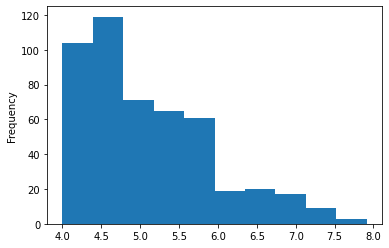

In [ ]:
mat_list0.band_gap.plot(kind='hist')  # Bandgap histogram
# most of bandgaps are around 4.5 eV

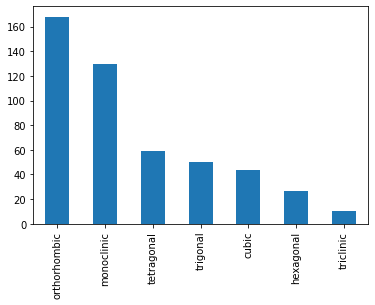

In [ ]:
mat_list0.crystal_system.value_counts().plot(kind='bar')  # Distribution of crystal phases

In [ ]:
mat_list0.groupby('crystal_system')['band_gap'].describe() # Gives the bandgap (describe()) statistics for each crystal phase

,count,mean,std,min,25%,50%,75%,max
crystal_system,,,,,,,,
cubic,44.0,5.574682,1.067004,4.0214,4.725600,5.38655,6.687150,7.2234
hexagonal,27.0,5.038304,0.848629,4.0464,4.323650,5.04040,5.565700,7.2052
monoclinic,130.0,5.060570,0.807054,4.0007,4.468450,4.80320,5.534625,7.5240
orthorhombic,168.0,5.140629,0.848986,4.0037,4.472800,4.92615,5.615325,7.9151
tetragonal,59.0,5.002112,0.735965,4.0286,4.397450,4.87830,5.666250,6.6478
triclinic,10.0,4.665440,0.469122,4.1914,4.367725,4.45275,5.025725,5.5374
trigonal,50.0,4.797666,0.560771,4.0065,4.279175,4.89250,5.138600,6.0618


#### Stable materials
Materials that are within Convex Hull (e_above_hull, more stable than their competing phases).

In [ ]:
mat_list1 = mat_list0[mat_list0['e_above_hull']==0] # only elements with e_above_hull equals to zero, define new dataframe

In [ ]:
mat_list1.describe() # only 249 compound now, compared to 488 before

,band_gap,formation_energy_per_atom,e_above_hull,symprec,number
count,249.000000,249.000000,249.0,2.490000e+02,249.000000
mean,5.066927,-2.869250,0.0,1.000000e-01,94.184739
std,0.861404,0.862347,0.0,1.390574e-17,72.576975
min,4.003700,-4.402006,0.0,1.000000e-01,2.000000
25%,4.394800,-3.511776,0.0,1.000000e-01,15.000000
50%,4.882400,-3.006038,0.0,1.000000e-01,62.000000
75%,5.602200,-2.292058,0.0,1.000000e-01,148.000000
max,7.646700,-0.277538,0.0,1.000000e-01,230.000000


### Fabrication

This data cannot be found in Materials Project. 
Lets use another database https://github.com/CederGroupHub/text-mined-synthesis_public. It uses NLP to read scientific articles and extract the fabrication process.

3 files to notice: <code>.json</code> compressed in <code>.xz</code>. Lets use the <code>solid-state_dataset_2019-12-03.json.xz</code>.

In [ ]:
!wget https://github.com/CederGroupHub/text-mined-synthesis_public/raw/master/solid-state_dataset_2019-12-03.json.xz && xz -d solid-state_dataset_2019-12-03.json.xz

--2023-02-06 08:50:09--  https://github.com/CederGroupHub/text-mined-synthesis_public/raw/master/solid-state_dataset_2019-12-03.json.xz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CederGroupHub/text-mined-synthesis_public/master/solid-state_dataset_2019-12-03.json.xz [following]
--2023-02-06 08:50:10--  https://raw.githubusercontent.com/CederGroupHub/text-mined-synthesis_public/master/solid-state_dataset_2019-12-03.json.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3391040 (3.2M) [application/octet-stream]
Saving to: ‘solid-state_dataset_2019-12-03.json.xz’

solid-state_dataset 100%[===

In [ ]:
synth_data = pd.read_json('solid-state_dataset_2019-12-03.json') # Charges .json into DataFrame

In [ ]:
synth_data.head()

,release_date,reactions
0,2019-12-03,"{'doi': '10.1016/j.materresbull.2007.07.027', ..."
1,2019-12-03,"{'doi': '10.1016/j.materresbull.2007.07.029', ..."
2,2019-12-03,"{'doi': '10.1016/j.materresbull.2007.07.041', ..."
3,2019-12-03,"{'doi': '10.1016/j.materresbull.2007.08.018', ..."
4,2019-12-03,"{'doi': '10.1016/j.materresbull.2007.08.018', ..."


In [ ]:
len(synth_data) # Entries, 30031 synthesis routes

30031

In [ ]:
synth_data['reactions'][0].keys() # reaction column has dictionary as inputs

dict_keys(['doi', 'targets_string', 'reaction_string', 'reaction', 'target', 'precursors', 'operations', 'paragraph_string'])

New columns for each key of dictionary with its value:

In [ ]:
synth_data[list(synth_data['reactions'][0].keys())] = synth_data.reactions.apply(pd.Series)
synth_data = synth_data.drop('reactions', axis=1) # deletes original reaction column

In [ ]:
synth_data.head()

,release_date,doi,targets_string,reaction_string,reaction,target,precursors,operations,paragraph_string
0,2019-12-03,10.1016/j.materresbull.2007.07.027,[Ba2HoTaO6],0.5 Ta2O5 + 2 BaCO3 + 0.5 Ho2O3 == 1 Ba2HoTaO6...,"{'element_substitution': {}, 'left_side': [{'m...","{'material_string': 'Ba2HoTaO6', 'material_for...","[{'material_string': 'Ta2O5', 'material_formul...","[{'token': 'dried', 'type': 'DryingOperation',...",All materials were obtained from Aldrich Chemi...
1,2019-12-03,10.1016/j.materresbull.2007.07.029,"[La3Nb0.5Ga5.3Al0.2O14, La3Nb0.5Ga5.3Al0.2O14]",1.5 La2O3 + 0.5*x Al2O3 + 2.75-0.5*x Ga2O3 + 0...,"{'element_substitution': {}, 'left_side': [{'m...","{'material_string': 'La3Nb0.5Ga5.5-xAlxO14', '...","[{'material_string': 'La2O3', 'material_formul...","[{'token': 'mixing', 'type': 'Mixing', 'condit...",The determination of the Al solubility limit i...
2,2019-12-03,10.1016/j.materresbull.2007.07.041,"[La9YGe6O27.005, La8.66YGe6O26.495, La8Y2Ge6O2...",0.5*x Y2O3 + 4.665+0.5*z-0.5*x La2O3 + 6 GeO2 ...,"{'element_substitution': {}, 'left_side': [{'m...",{'material_string': 'La9.33+z-xYx(GeO4)6O2+3z/...,"[{'material_string': 'Y2O3', 'material_formula...","[{'token': 'mixed', 'type': 'Mixing', 'conditi...","Samples, La9.33+z-xYx(GeO4)6O2+3z/2 (0 ≤ z ≤ 0..."
3,2019-12-03,10.1016/j.materresbull.2007.08.018,[CaTi4Cu3O12],3 CuO + 4 TiO2 + 1 CaCO3 == 1 CaCu3Ti4O12 + 1 CO2,"{'element_substitution': {}, 'left_side': [{'m...","{'material_string': 'CaCu3Ti4O12 oxide', 'mate...","[{'material_string': 'CuO', 'material_formula'...","[{'token': 'milled', 'type': 'LiquidGrinding',...","High-purity CaCO3 (99.99%), CuO (99.99%), and ..."
4,2019-12-03,10.1016/j.materresbull.2007.08.018,[Nb2ZnO6],1 ZnO + 1 Nb2O5 == 1 ZnNb2O6,"{'element_substitution': {}, 'left_side': [{'m...","{'material_string': 'ZnNb2O6', 'material_formu...","[{'material_string': 'ZnO', 'material_formula'...","[{'token': 'milled', 'type': 'Mixing', 'condit...",ZnNb2O6 powder was synthesized using high-puri...


Lets try to check if the compounds in <code>target</code> are in our original list of compounds: 

In [ ]:
synth_data['target'][0].keys()

dict_keys(['material_string', 'material_formula', 'composition', 'amounts_vars', 'elements_vars', 'additives', 'oxygen_deficiency', 'mp_id'])

In [ ]:
# again, lets turn the dict into columns
synth_data[list(synth_data['target'][0].keys())] = synth_data.target.apply(pd.Series)
synth_data = synth_data.drop('target', axis=1) # deletes original

In [ ]:
synth_data.head()

,release_date,doi,targets_string,reaction_string,reaction,precursors,operations,paragraph_string,material_string,material_formula,composition,amounts_vars,elements_vars,additives,oxygen_deficiency,mp_id
0,2019-12-03,10.1016/j.materresbull.2007.07.027,[Ba2HoTaO6],0.5 Ta2O5 + 2 BaCO3 + 0.5 Ho2O3 == 1 Ba2HoTaO6...,"{'element_substitution': {}, 'left_side': [{'m...","[{'material_string': 'Ta2O5', 'material_formul...","[{'token': 'dried', 'type': 'DryingOperation',...",All materials were obtained from Aldrich Chemi...,Ba2HoTaO6,Ba2HoTaO6,"[{'formula': 'Ba2HoTaO6', 'elements': {'Ba': '...",{},{},[],None,mp-13000
1,2019-12-03,10.1016/j.materresbull.2007.07.029,"[La3Nb0.5Ga5.3Al0.2O14, La3Nb0.5Ga5.3Al0.2O14]",1.5 La2O3 + 0.5*x Al2O3 + 2.75-0.5*x Ga2O3 + 0...,"{'element_substitution': {}, 'left_side': [{'m...","[{'material_string': 'La2O3', 'material_formul...","[{'token': 'mixing', 'type': 'Mixing', 'condit...",The determination of the Al solubility limit i...,La3Nb0.5Ga5.5-xAlxO14,La3Nb0.5Ga5.5-xAlxO14,"[{'formula': 'La3Nb0.5Ga5.5-xAlxO14', 'element...","{'x': {'values': [0.2, 0.2], 'max_value': 0.2,...",{},[],None,None
2,2019-12-03,10.1016/j.materresbull.2007.07.041,"[La9YGe6O27.005, La8.66YGe6O26.495, La8Y2Ge6O2...",0.5*x Y2O3 + 4.665+0.5*z-0.5*x La2O3 + 6 GeO2 ...,"{'element_substitution': {}, 'left_side': [{'m...","[{'material_string': 'Y2O3', 'material_formula...","[{'token': 'mixed', 'type': 'Mixing', 'conditi...","Samples, La9.33+z-xYx(GeO4)6O2+3z/2 (0 ≤ z ≤ 0...",La9.33+z-xYx(GeO4)6O2+3z/2,La9.33+z-xYx(GeO4)6O2+3z/2,"[{'formula': 'La9.33+z-xYx(GeO4)6O2+3z/2', 'el...","{'z': {'values': [0.67, 0.33], 'max_value': 0....",{},[],None,None
3,2019-12-03,10.1016/j.materresbull.2007.08.018,[CaTi4Cu3O12],3 CuO + 4 TiO2 + 1 CaCO3 == 1 CaCu3Ti4O12 + 1 CO2,"{'element_substitution': {}, 'left_side': [{'m...","[{'material_string': 'CuO', 'material_formula'...","[{'token': 'milled', 'type': 'LiquidGrinding',...","High-purity CaCO3 (99.99%), CuO (99.99%), and ...",CaCu3Ti4O12 oxide,CaCu3Ti4O12 oxide,"[{'formula': 'CaCu3Ti4O12', 'elements': {'Ca':...",{},{},[],None,mp-22592
4,2019-12-03,10.1016/j.materresbull.2007.08.018,[Nb2ZnO6],1 ZnO + 1 Nb2O5 == 1 ZnNb2O6,"{'element_substitution': {}, 'left_side': [{'m...","[{'material_string': 'ZnO', 'material_formula'...","[{'token': 'milled', 'type': 'Mixing', 'condit...",ZnNb2O6 powder was synthesized using high-puri...,ZnNb2O6,ZnNb2O6,"[{'formula': 'ZnNb2O6', 'elements': {'Zn': '1'...",{},{},[],None,None


 <code>mp_id</code> column: identification inside materialsproject.org, let's then compare the two dataframes.

In [ ]:
mat_list2 = mat_list1.merge(synth_data, left_on='material_id', right_on='mp_id')

In [ ]:
mat_list2.head()

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,symprec,source,symbol,...,operations,paragraph_string,material_string,material_formula,composition,amounts_vars,elements_vars,additives,oxygen_deficiency,mp_id
0,mp-5525,"[262971, 91842, 262972, 88774, 262969, 262970,...",KAlO2,"[Al, K, O]",4.0037,-2.922292,0.0,0.1,spglib,Pbca,...,[],A series of gallium-aluminium silicate inorgan...,KAlO2,KAlO2,"[{'formula': 'KAlO2', 'elements': {'K': '1', '...",{},{},[],None,mp-5525
1,mp-5525,"[262971, 91842, 262972, 88774, 262969, 262970,...",KAlO2,"[Al, K, O]",4.0037,-2.922292,0.0,0.1,spglib,Pbca,...,"[{'token': 'homogenized', 'type': 'Mixing', 'c...",Solid state synthesis route was followed for t...,K2Al2O4,K2Al2O4,"[{'formula': 'K2Al2O4', 'elements': {'K': '2',...",{},{},[],None,mp-5525
2,mp-28022,[35070],Na6CdCl8,"[Cd, Cl, Na]",4.0214,-1.990353,0.0,0.1,spglib,Fm-3m,...,[],Nineteen kinds of halogenocadmate crystals lis...,Na6CdCl8,Na6CdCl8,"[{'formula': 'Na6CdCl8', 'elements': {'Na': '6...",{},{},[],None,mp-28022
3,mp-28022,[35070],Na6CdCl8,"[Cd, Cl, Na]",4.0214,-1.990353,0.0,0.1,spglib,Fm-3m,...,[],Nineteen kinds of halogenocadmate crystals lis...,Na6CdCl8,Na6CdCl8,"[{'formula': 'Na6CdCl8', 'elements': {'Na': '6...",{},{},[],None,mp-28022
4,mp-558781,"[109192, 236604]",ScTaO4,"[Sc, Ta, O]",4.0277,-3.663437,0.0,0.1,spglib,P2/c,...,"[{'token': 'milled', 'type': 'Mixing', 'condit...",PST ceramic samples were fabricated using the ...,ScTaO4,ScTaO4,"[{'formula': 'ScTaO4', 'elements': {'Sc': '1',...",{},{},[],None,mp-558781


As it is possible to have more than one fabrication route for the same material, the df went from 249 to 340 lines. Let's remove the duplicates.

In [ ]:
len(mat_list2) #df with more lines due to duplicates in fabrication process

340

In [ ]:
mat_list3 = mat_list2.drop_duplicates(subset=['material_id']) 
# let's drop the duplicates basing on the column material_id

In [ ]:
len(mat_list3) # reduced df, only 38 metarials inside the requirements below

38

Only 38 materials (<code>mat_list3</code>) fufill all the criteria desired:

- [x] Ternary materials
- [x] Non-radioactive elements
- [x] Bandgap between 4 and 12 eV
- [x] Direct bandgap
- [x] Band structure
- [x] ICSD entry
- [x] Thermodynamically stable
- [x] Known fabrication

Final df is:

In [ ]:
mat_list3['pretty_formula'].values # the compounds

array(['KAlO2', 'Na6CdCl8', 'ScTaO4', 'NaErO2', 'BaMoO4', 'Li4GeO4',
       'LaClO', 'CaWO4', 'LiYO2', 'Tb3Al5O12', 'Sr2SiO4', 'Y3Al5O12',
       'Ba2Si3O8', 'LiAlO2', 'NaAl11O17', 'Ba2SiO4', 'SrWO4', 'Lu2SiO5',
       'Zn(PO3)2', 'Er3Al5O12', 'Er2SiO5', 'Y2SiO5', 'NdClO', 'SmAlO3',
       'Al2SiO5', 'Lu2Si2O7', 'Na2WO4', 'Lu3Al5O12', 'Sr2P2O7', 'MgAl2O4',
       'Mg2SiO4', 'BaClF', 'Ba(PO3)2', 'TbPO4', 'LuPO4', 'NaAlF4',
       'NaMgF3', 'CaAlF5'], dtype=object)

Let's take one of them to study in depth: **CaAlF5**

In [ ]:
selected_material = mat_list2[mat_list2['pretty_formula']=='CaAlF5'] 
# select all features of this material

In [ ]:
selected_material

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,symprec,source,symbol,...,operations,paragraph_string,material_string,material_formula,composition,amounts_vars,elements_vars,additives,oxygen_deficiency,mp_id
339,mp-8836,[69563],CaAlF5,"[Al, Ca, F]",7.1538,-4.057218,0.0,0.1,spglib,C2/c,...,"[{'token': 'mixing', 'type': 'Mixing', 'condit...",Owing to the fact that fluoride compounds are ...,β-CaAlF5,β-CaAlF5,"[{'formula': 'CaAlF5', 'elements': {'Ca': '1',...",{},{},[],None,mp-8836


In [ ]:
selected = 'mp-8836' # ID Materials Project

In [ ]:
selected_material.keys() # features

Index(['material_id', 'icsd_ids', 'pretty_formula', 'elements', 'band_gap',
       'formation_energy_per_atom', 'e_above_hull', 'symprec', 'source',
       'symbol', 'number', 'point_group', 'crystal_system', 'hall',
       'release_date', 'doi', 'targets_string', 'reaction_string', 'reaction',
       'precursors', 'operations', 'paragraph_string', 'material_string',
       'material_formula', 'composition', 'amounts_vars', 'elements_vars',
       'additives', 'oxygen_deficiency', 'mp_id'],
      dtype='object')

### Rota de Síntese **CaAlF5**

In [ ]:
selected_material['reaction_string'].values # synthesis equation

array(['1 AlF3 + 1 CaF2 == 1 CaAlF5'], dtype=object)

In [ ]:
selected_material['operations'].values #recipy for fabrication

array([list([{'token': 'mixing', 'type': 'Mixing', 'conditions': None}, {'token': 'heated', 'type': 'HeatingOperation', 'conditions': {'heating_temperature': [{'max_value': 850.0, 'min_value': None, 'values': [850.0], 'units': 'C'}], 'heating_time': [{'max_value': 96.0, 'min_value': None, 'values': [96.0], 'units': 'h'}], 'heating_atmosphere': [], 'mixing_media': [], 'mixing_device': []}}, {'token': 'quenched', 'type': 'QuenchingOperation', 'conditions': None}])],
      dtype=object)

### Electronic Structure **CaAlF5**

From Materials Project:

In [ ]:
with MPRester(apikey) as mpr:
    bs = mpr.get_bandstructure_by_material_id(selected) # using MP id

/usr/local/lib/python3.8/dist-packages/pymatgen/ext/matproj.py:186: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


In [ ]:
bs.get_band_gap() # type of electronic transition

{'direct': True, 'energy': 7.1538, 'transition': '\\Gamma-\\Gamma'}

In [ ]:
efermi=bs.efermi
print(efermi)  # Fermi energy eV

-1.52072964


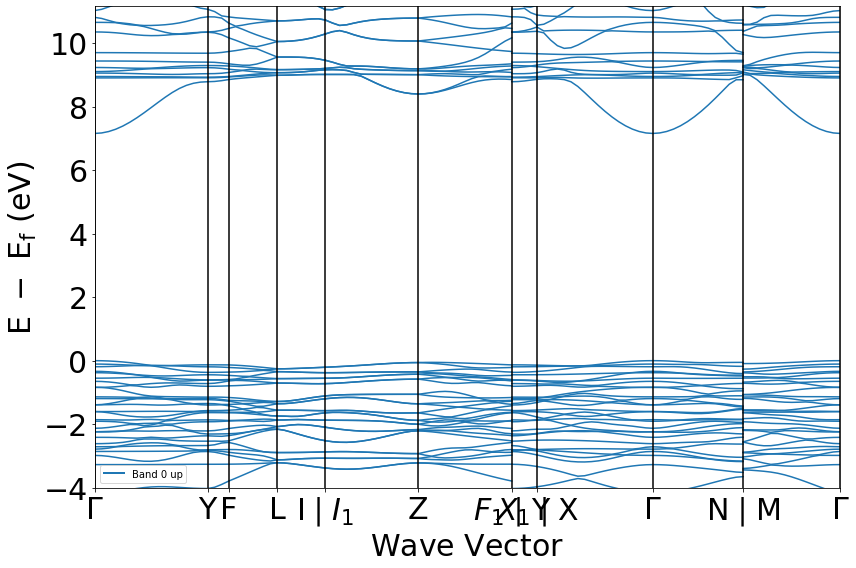

In [ ]:
bsp = BSPlotter(bs)
bsp.get_plot(zero_to_efermi=True).show() # Pymatgen automatic plotting
#bsp.bs_plot_data(zero_to_efermi=True)   # Extract in the dict form to plot manually

### Crystal Structure **CaAlF5**

Downloaded from Materials Project (it is also possible to use <code>bs</code> to store the crystal structure information).

In [ ]:
with MPRester(apikey) as mpr:
    structure = mpr.get_structure_by_material_id(selected)

/usr/local/lib/python3.8/dist-packages/pymatgen/ext/matproj.py:186: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


In [ ]:
structure.atomic_numbers

(20, 20, 13, 13, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9)

In [ ]:
structure.cart_coords # atomic positions

array([[ 0.26591513,  5.1967495 ,  1.68521975],
       [-0.26591513,  6.7708065 ,  5.05565925],
       [ 0.        ,  1.574057  ,  3.3704395 ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.1095689 ,  8.79195695,  4.13598765],
       [-0.1095689 ,  4.74965605,  5.97533085],
       [ 0.1095689 ,  3.17559905,  2.60489135],
       [ 0.1095689 ,  7.21789995,  0.76554815],
       [-2.83175525,  6.7708065 ,  5.05565925],
       [ 2.83175525,  5.1967495 ,  1.68521975],
       [-1.38652086,  4.58958106,  0.17569427],
       [-1.38652086,  5.80391794,  3.19474523],
       [ 1.38652086,  7.37797494,  6.56518473],
       [ 1.38652086,  6.16363806,  3.54613377]])

In [ ]:
structure.lattice # lattice parameters

Lattice
    abc : 5.450502239609209 5.450502239609209 7.439762862459864
 angles : 69.98009713859915 69.98009713859915 71.99384548135231
 volume : 190.44989674275448
      A : 3.203488 4.409721 0.0
      B : -3.203488 4.409721 0.0
      C : 0.0 3.148114 6.740879
    pbc : True True True

Let's save the structure in a file of type <code>POSCAR</code> inside the folder <code>proto_CaAlF5</code>, located inside <code>ht</code>. 

In [ ]:
poscar = vasp.inputs.Poscar(structure) 
# using the vasp library to generate the Poscar file

In [ ]:
# creating folder names for high-throughput
master_folder = 'ht'
material_folder = 'proto_CaAlF5'
filename = 'POSCAR'

In [ ]:
# creating folders for high-throughput
os.mkdir(master_folder)
os.mkdir(master_folder+'/'+material_folder)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# writing the POSCAR file inside created folders
poscar.write_file(master_folder+'/'+material_folder+'/'+filename)

Target question: **if we can each element of this compound for another one with similar chemical properties, do we still get a UWBG stable and possible to fabricate?**

- UWBG: ultrawide bandgap
-------------------------------------------------

# Section 2 - Configurating entries for HT jobs 

The substitution of elements will be done by using other elements of the same column in the periodic table (not considering radioactive ones such as Ra and At).

As a quantum mechanics solver, let's use the VASP code.

The calculations will be carried in a cluster using a queue manager such as SLURM.

obs: for calculation clusters without queue manager, better to use ASE (https://wiki.fysik.dtu.dk/ase/) to submit the calculations directly using Python. For sending high quantity of jobs, also using queue manager, better to use AiiDA (https://www.aiida.net/).

### Creating new materials and configurating VASP files

- Launching jobs to calculate the ionic positions and optimize structure (to converge!)

- Lets use the same crystal structure as **CaAlF5**, just changing the atoms

- Atoms to substitute: Be, Mg, Sr, Ba (columns 2 of periodic table); B, Ga, In, Tl (column 13) and Cl, Br, I (column 17); plus Ca, Al and F that I already had. 

- This gives a combination of 5 x 5 x 4, giving 100 compounds (but one, CaAlF5) I already have.

- Lets then simulate all the 99 in a high-throughput manner:

In [ ]:
input_folder = 'ht/proto_CaAlF5'  
# Our initial crystal structure (POSCAR) used as prototype
proto_poscar = Structure.from_file(input_folder+"/POSCAR")  
# propotype structure

In [ ]:
proto_poscar

Structure Summary
Lattice
    abc : 5.450502239609209 5.450502239609209 7.439762862459864
 angles : 69.98009713859915 69.98009713859915 71.99384548135231
 volume : 190.44989674275448
      A : 3.203488 4.409721 0.0
      B : -3.203488 4.409721 0.0
      C : 0.0 3.148114 6.740879
    pbc : True True True
PeriodicSite: Ca (0.2659, 5.1967, 1.6852) [0.5415, 0.4585, 0.2500]
PeriodicSite: Ca (-0.2659, 6.7708, 5.0557) [0.4585, 0.5415, 0.7500]
PeriodicSite: Al (0.0000, 1.5741, 3.3704) [0.0000, 0.0000, 0.5000]
PeriodicSite: Al (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: F (-0.1096, 8.7920, 4.1360) [0.7608, 0.7950, 0.6136]
PeriodicSite: F (-0.1096, 4.7497, 5.9753) [0.2050, 0.2392, 0.8864]
PeriodicSite: F (0.1096, 3.1756, 2.6049) [0.2392, 0.2050, 0.3864]
PeriodicSite: F (0.1096, 7.2179, 0.7655) [0.7950, 0.7608, 0.1136]
PeriodicSite: F (-2.8318, 6.7708, 5.0557) [0.0580, 0.9420, 0.7500]
PeriodicSite: F (2.8318, 5.1967, 1.6852) [0.9420, 0.0580, 0.2500]
PeriodicSite: F (-1.3865, 4

Setting VASP configuration to launch jobs:

In [ ]:
incar_rx = {
"ALGO": "Normal",
"EDIFF": "0.000001",
"ENCUT": 520,
"IBRION": 2,
"ISIF": 3,
"ISMEAR": 0,
"ISPIN": 1,
"LASPH": True,
"LORBIT": 11,
"LREAL": "Auto",
"LWAVE": False,
"LCHARG":False,
"NELM": 100,
"NSW": 900,
"SIGMA": 0.05,
"NPAR": 6
}

auto_kpoints = 25

Creating the folder structure to launch the files containing all the new combination of compounds:

In [ ]:
# List of elements to substitute
earthalk_list = ['Be','Mg','Ca','Sr','Ba']
boron_list = ['B','Al','Ga','In','Tl']
halogen_list = ['F','Cl','Br','I']

In [ ]:
# generating 100 POSCAR files, for each element combination
# generates also the INCAR and KPOINTS input files requested by VASP

calculations_folder = 'ht/rx'
os.mkdir(calculations_folder)
pseudos_src_path = 'pp/'

for e1 in earthalk_list:
    for e2 in boron_list:
        for e3 in halogen_list:
            
            # New folder for new combination of materials
            output_folder=calculations_folder+'/'+e1+e2+e3+'5'
            os.mkdir(output_folder)
            
            temp_structure = proto_poscar.copy()          # Copy original structure

            if not(e1=='Ca' and e2=='Al' and e3=='F'):
                for i, element in enumerate(proto_poscar):    # for each atom in structure
                    element_str = str(element.species)        # take atom from site
                    element_str = element_str.replace('1','') # removes stoichiometry (in this case 1)

                    # change elements from the same family
                    if element_str in earthalk_list:
                        temp_structure.replace(i,e1)
                    elif element_str in boron_list:
                        temp_structure.replace(i,e2)
                    elif element_str in halogen_list:
                        temp_structure.replace(i,e3)

            # creates new POSCAR file in the final folder
            new_poscar = vasp.inputs.Poscar(temp_structure)
            new_poscar.write_file(output_folder+'/POSCAR')
            
            # creates new KPOINTQ file in the final folder
            kpoints = vasp.Kpoints().automatic(auto_kpoints)  # auto_kpoints (25)
            kpoints.write_file(output_folder+'/KPOINTS')
            
            # creates new INCAR file in the final folder
            incar = vasp.Incar(incar_rx)
            incar.write_file(output_folder+'/INCAR')
            
            # creates POTCAR in final folder:
            # create_potcar(compound, pseudos_src_path,  best_choice, dst_path)
            
            # creates job in final folder:
            # create_jobfile(protojob_path, job_name, time, job_dst_path)

We can zip the files and then use them later to submit the jobs:

In [ ]:
!zip -r '/content/ht_todo.zip' '/content/ht/'

  adding: content/ht/ (stored 0%)
  adding: content/ht/proto_CaAlF5/ (stored 0%)
  adding: content/ht/proto_CaAlF5/POSCAR (deflated 79%)
  adding: content/ht/rx/ (stored 0%)
  adding: content/ht/rx/SrTlCl5/ (stored 0%)
  adding: content/ht/rx/SrTlCl5/INCAR (deflated 25%)
  adding: content/ht/rx/SrTlCl5/KPOINTS (deflated 9%)
  adding: content/ht/rx/SrTlCl5/POSCAR (deflated 79%)
  adding: content/ht/rx/MgAlI5/ (stored 0%)
  adding: content/ht/rx/MgAlI5/INCAR (deflated 25%)
  adding: content/ht/rx/MgAlI5/KPOINTS (deflated 9%)
  adding: content/ht/rx/MgAlI5/POSCAR (deflated 79%)
  adding: content/ht/rx/MgBF5/ (stored 0%)
  adding: content/ht/rx/MgBF5/INCAR (deflated 25%)
  adding: content/ht/rx/MgBF5/KPOINTS (deflated 9%)
  adding: content/ht/rx/MgBF5/POSCAR (deflated 79%)
  adding: content/ht/rx/BeTlCl5/ (stored 0%)
  adding: content/ht/rx/BeTlCl5/INCAR (deflated 25%)
  adding: content/ht/rx/BeTlCl5/KPOINTS (deflated 9%)
  adding: content/ht/rx/BeTlCl5/POSCAR (deflated 79%)
  adding: cont

----------------------------
### Annexe: how to create <code>JOB</code> and <code>POTCAR</code> files



<pre><code>
# INPUT: takes address of pseudopotential folder (full address of PBE, GGA, etc potencials)
# OUTPUT: creates POTCAR file and returns success flag (True) or fail (False)
def create_potcar(compound, pseudos_src_path,  best_choice, dst_path):

    # if the final folder does not exist:
    if not os.path.exists(dst_path):
        os.mkdir(dst_path)

    comp1 = Composition(compound)
    elements=[]
    final_file = []
    for elem in comp1.formula.split(" "):
        n = re.sub('\D', '', elem)
        element = elem.replace(n,'')

        if element in best_choice.keys():
            element_path = pseudos_src_path+'/'+element+best_choice[element]+'/POTCAR'
            #print(element_path)
            # if a better choice of PSEUDOS folder does not exist 
            if not(os.path.isfile(element_path)):
                element_path = pseudos_src_path+'/'+element+'/POTCAR'
        else:
             element_path = pseudos_src_path+'/'+element+'/POTCAR'

        #print(element_path)

        # if POTCAR file exists
        if os.path.isfile(element_path):
            with open(element_path, 'r') as file:
                x = file.readlines()
            final_file = final_file+x
            response=True
        else:
            print("Not found POTCAR of: "+element)
            response=False
            break

    if response and len(final_file)>0:
        complete_dst_path = dst_path+'/POTCAR'
        with open(complete_dst_path, 'w') as file:
            file.writelines(final_file)

    return response


# INPUT: job protopyte address, job name, time limit, output address
# OUTPUT: creates job file in final folder and returns success flag (True) or fail (False)
def create_jobfile(protojob_path, job_name, time, job_dst_path):

    if os.path.isfile(protojob_path):
        # creates folder to put job file inside in case it does not exists
        if not os.path.exists(job_dst_path):
            os.mkdir(job_dst_path)

        # charges job prototype
        with open(protojob_path, 'r') as file:
            job = file.readlines()

        new_job=[]
        for line in job:
            line = line.replace('jobname',job_name)
            line = line.replace('xx:xx:xx',time)
            new_job.append(line)

        complete_path = job_dst_path+'/'+job_name
        #complete_path = job_dst_path+'/JOB'

        with open(complete_path,'w') as file:
            file.writelines(new_job)

        response=True

    else:
        print('Job proto file not found')
        response = False

    return response
</code></pre>
------------------------------------------------

# Section 3 - Submitting the jobs into a quantum mechanics solver (VASP code)

Below, let's use "pure python" to submit, but other libraries can be used: ASE (for a local computer) and AiiDA (for clusters with scheduler and complex job management. 

Use a dedicated script <code>.py</code>, to be charged inside the cluster. obs: <code>JOB</code> files needes to be inside the correct <code>folder</code> together with other inputs of Vasp.

#### Script for launching and managing <code>JOBS</code> inside cluster

<pre><code>
import os
import shutil
import time
import subprocess
import argparse

# Returns number of free spaces inside SLURM
def check_free_spot(user):

    temp = 'check_free_spot.txt'
    script = f'''squeue -u {user} > {temp}'''

    count_lines = subprocess.Popen(script, stdout=subprocess.PIPE, shell=True)
    time.sleep(2)
    with open(temp, 'r') as file:
        lines = file.readlines()

    n_lines = 21-len(lines)

    os.remove(temp)

    return n_lines

# Submits script command
def submit_job(job_path):

    job = job_path.split('/')[-1]
    shell_command='sbatch '+job
    job_path=job_path.replace(job,'')

    submit = subprocess.Popen(shell_command,
                              stdout=subprocess.PIPE,
                              shell=True,
                              cwd=job_path)
    status = submit.communicate()[0].decode('UTF-8')

    if status.split()[0] == 'Submitted':
        print('Submission successful.')
        response=True
    else:
        print('Submission failed.')
        response=False

    return(response)


def main():
    parser = argparse.ArgumentParser()

    parser.add_argument('-jb', '--jobs', default = 'jobs_submetidos.txt',
                        help = 'Nome do arquivo de jobs submetidos.', type = str)

    parser.add_argument('-fjb', '--fjobs', default = 'jobs_afazer',
                        help = 'Pasta com arquivos de jobs a serem submetidos.', type = str)

    parser.add_argument('-u', '--user', default = 'usuario_da_sd',
                        help = 'Usuario do SLURM.', type = str)

    args = parser.parse_args()
    # verifies is a file exists with the jobs already launched
    if not(os.path.isfile(args.jobs)):
        f= open(args.jobs,"w+")
        f.close()
        nfeitos=0
    else:
        with open(args.jobs, 'r') as file:
            jobs_prontos = file.readlines()
        nfeitos=len(jobs_prontos)


    sleep_time = 1800
    qts_jobs = len(os.listdir(args.fjobs))
    todo_jobs = qts_jobs-nfeitos # quantity of jobs to be done
    i = 0


    while(i<todo_jobs):

        with open(args.jobs, 'r') as file:
            jobs_prontos = file.readlines()

        jobs_prontos=[job.replace('\n','') for job in jobs_prontos] # So tira o \n

        for folder in os.listdir(args.fjobs):
            # O job ainda nao foi submetido
            if not(folder in jobs_prontos):
                n_lines = check_free_spot(args.user)
                # Tem espaco para colocar na fila
                if n_lines>0:
                    job_folder = args.fjobs+'/'+folder
                    job_file = [file for file in os.listdir(job_folder) if 'job' in file][0]
                    submit_job(job_folder+'/'+job_file)
                    with open(args.jobs, 'a') as file:
                        file.write(folder+'\n')
                    i = i+1
                else:
                    break
        time.sleep(sleep_time)

if __name__ == "__main__":
    main()
</code></pre>

-------------------------------

# Section 4 - Data Analysis

DFT results on the geometrical optimization of the semiconductor alloys:

Important reference:
- H. Ferreira, J. A. Souza, and G. M. Dalpian, **High-throughput Calculations to Discovery New Compounds: the case of Jakobssonite**, Encontro de Outono da Sociedade Brasileira de Física, 2022.


### Loading data

Using only <code>CONTCAR</code> (crystal structure file) and <code>EIGENVAL</code> (bandgap).

In [ ]:
# Unzip DFT results .rar file
!unrar x drive/MyDrive/results_bs/results_bs.rar


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from drive/MyDrive/results_bs/results_bs.rar

Creating    results_bs                                                OK
Creating    results_bs/BaAlBr5                                        OK
Extracting  results_bs/BaAlBr5/CONTCAR                                     0%  OK 
Extracting  results_bs/BaAlBr5/EIGENVAL                                    0%  OK 
Creating    results_bs/BaAlCl5                                        OK
Extracting  results_bs/BaAlCl5/CONTCAR                                     0%  OK 
Extracting  results_bs/BaAlCl5/EIGENVAL                                    2%  OK 
Creating    results_bs/BaAlF5                                         OK
Extracting  results_bs/BaAlF5/CONTCAR                                      2%  OK 
Extracting  results_bs/BaAlF5/EIGENVAL                                     3%  OK 
Creating    results_bs/

In [ ]:
calculations_results = 'results_bs'
results = []
for e1 in earthalk_list:
    for e2 in boron_list:
        for e3 in halogen_list:
            
            folder=f'{calculations_results}/{e1}{e2}{e3}5'
            
            # Loading files
            contcar = Structure.from_file(f'{folder}/CONTCAR')
            eigenval = vasp.outputs.Eigenval(f'{folder}/EIGENVAL')
            
            # solves results into dic
            band = eigenval.eigenvalue_band_properties 

            proprieties = {
                'material':f'{e1}{e2}{e3}5',
                'A':e1,
                'B':e2,
                'C':e3,
                'bandgap':band[0],
                'cbm':band[1],
                'vbm':band[2],
                'bandgap_direct':band[3],
                'lattice_a':contcar.lattice.a,
                'lattice_b':contcar.lattice.b,
                'lattice_c':contcar.lattice.c,
                'lattice_alpha':contcar.lattice.alpha,
                'lattice_beta':contcar.lattice.beta,
                'lattice_gamma':contcar.lattice.gamma
            }
            results.append(proprieties) # transforms dic into list
            

In [ ]:
results_df = pd.DataFrame(data=results)  # Transforming into df

In [ ]:
results_df.head()

,material,A,B,C,bandgap,cbm,vbm,bandgap_direct,lattice_a,lattice_b,lattice_c,lattice_alpha,lattice_beta,lattice_gamma
0,BeBF5,Be,B,F,7.215247,4.623167,-2.592080,True,5.137239,5.141555,9.477953,123.430231,56.544091,122.173758
1,BeBCl5,Be,B,Cl,4.864420,1.425657,-3.438763,False,7.790373,7.762067,10.530760,115.351539,64.603085,108.196125
2,BeBBr5,Be,B,Br,3.883992,0.861019,-3.022973,False,8.186414,8.214125,11.804317,116.866052,63.329587,117.455505
3,BeBI5,Be,B,I,2.766870,2.010463,-0.756407,False,8.628103,8.648576,11.983029,115.132217,64.378342,114.868954
4,BeAlF5,Be,Al,F,7.786402,6.512569,-1.273833,True,4.811944,4.811913,7.439838,112.740046,67.273112,98.664274


In [ ]:
len(results_df)

100

Basic stats with <code>.describe</code>:

In [ ]:
results_df.describe()

,bandgap,cbm,vbm,lattice_a,lattice_b,lattice_c,lattice_alpha,lattice_beta,lattice_gamma
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.298613,2.355679,-0.942934,7.269389,7.200288,10.788109,113.984287,71.342997,103.966979
std,1.751008,1.402202,1.403827,1.510483,1.443463,2.020007,5.282402,15.696749,11.686330
min,0.000252,-1.935510,-3.438763,4.811944,4.811913,7.295984,101.450104,50.172336,73.694311
25%,1.951422,1.438639,-1.854169,6.448909,6.348501,9.289077,110.249121,63.283595,93.938542
50%,3.006526,2.484666,-1.048037,7.270441,7.291892,10.967104,112.338908,67.687879,106.562708
75%,4.704026,3.404987,-0.219678,7.847228,7.734614,12.058363,116.229366,69.901668,114.082750
max,7.786402,6.512569,5.473483,16.659805,16.659805,18.412130,131.019347,112.291659,128.002970


### Data visualization
1) **Bandgap Dispersion** as function of crystalline structure

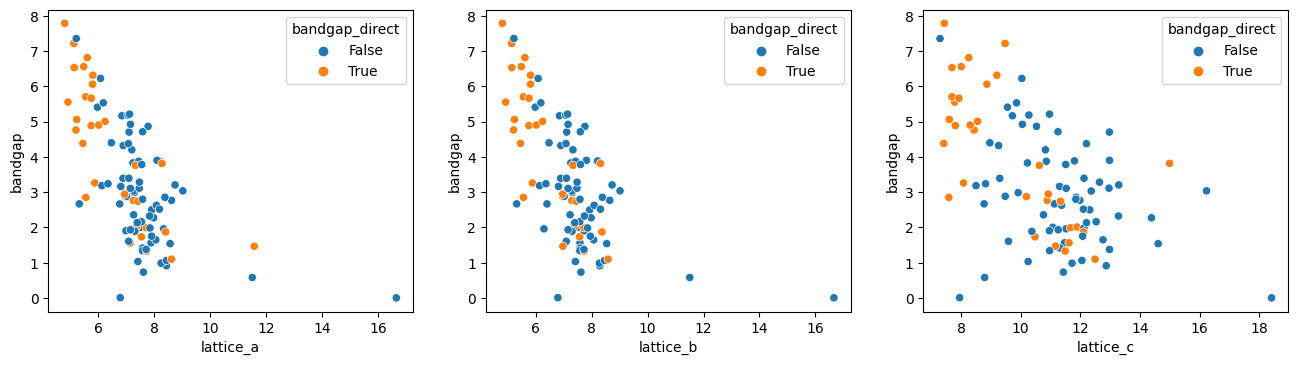

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(16,4), dpi=100) 

sns.scatterplot(data=results_df, x="lattice_a", y="bandgap", hue='bandgap_direct', ax=ax[0])
sns.scatterplot(data=results_df, x="lattice_b", y="bandgap", hue='bandgap_direct', ax=ax[1])
sns.scatterplot(data=results_df, x="lattice_c", y="bandgap", hue='bandgap_direct', ax=ax[2])

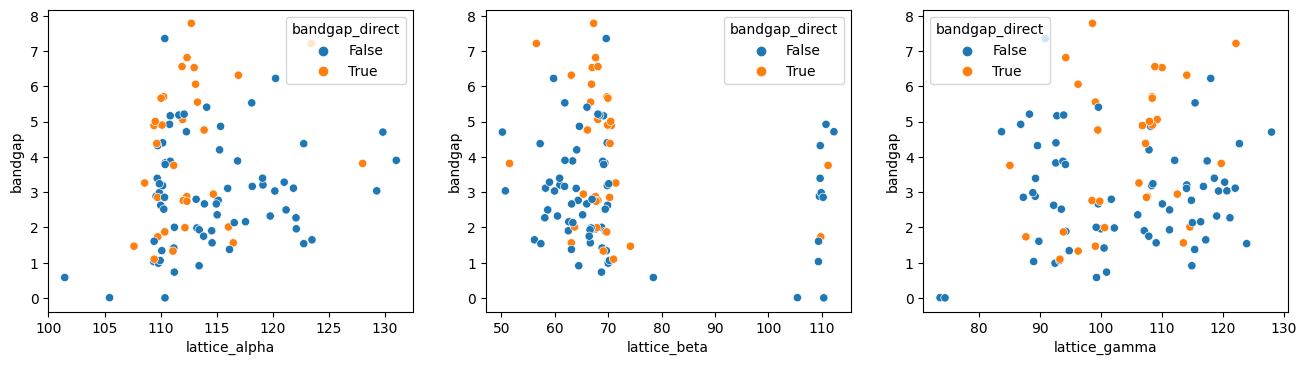

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(16,4), dpi=100)

sns.scatterplot(data=results_df, x="lattice_alpha", y="bandgap", hue='bandgap_direct', ax=ax[0])
sns.scatterplot(data=results_df, x="lattice_beta", y="bandgap", hue='bandgap_direct', ax=ax[1])
sns.scatterplot(data=results_df, x="lattice_gamma", y="bandgap", hue='bandgap_direct', ax=ax[2])

### 2) **Bandgap** as function of group element:

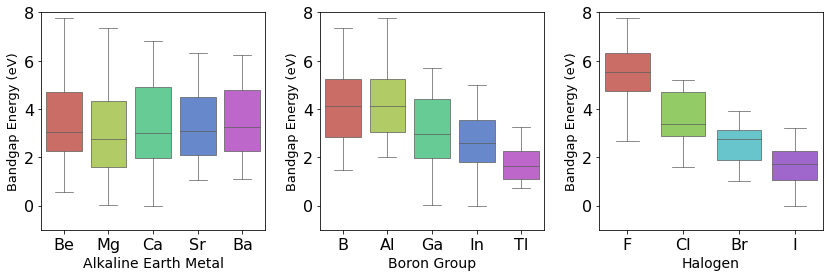

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.boxplot(x="A", y="bandgap", data=results_df,
            palette="hls", linewidth=0.7, ax=axes[0],
            order=['Be','Mg','Ca','Sr', 'Ba'],
           )

sns.boxplot(x="B", y="bandgap", data=results_df, 
            palette="hls", linewidth=0.7, ax=axes[1],
            order=['B','Al','Ga','In', 'Tl'],
           )

sns.boxplot(x="C", y="bandgap", data=results_df,
            palette="hls", linewidth=0.7, ax=axes[2],
            order=['F','Cl','Br','I'],
           )

### Ajustes
axes[0].set_xlabel('Alkaline Earth Metal',  fontsize=14)
axes[1].set_xlabel('Boron Group',  fontsize=14)
axes[2].set_xlabel('Halogen',  fontsize=14)

axes[0].set_ylim([-1,8])
axes[1].set_ylim([-1,8])
axes[2].set_ylim([-1,8])

axes[0].set_ylabel('Bandgap Energy (eV)',  fontsize=13)
axes[1].set_ylabel('Bandgap Energy (eV)',  fontsize=13)
axes[2].set_ylabel('Bandgap Energy (eV)',  fontsize=13)

axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[0].tick_params(axis='both', which='minor', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=16)
axes[1].tick_params(axis='both', which='minor', labelsize=16)
axes[2].tick_params(axis='both', which='major', labelsize=16)
axes[2].tick_params(axis='both', which='minor', labelsize=16)

plt.subplots_adjust(wspace=0.25)
#plt.savefig('bandgap_boxplot.png', transparent=True) Para salvar a imagem

### 3) **Direct or indirect bandgap**:

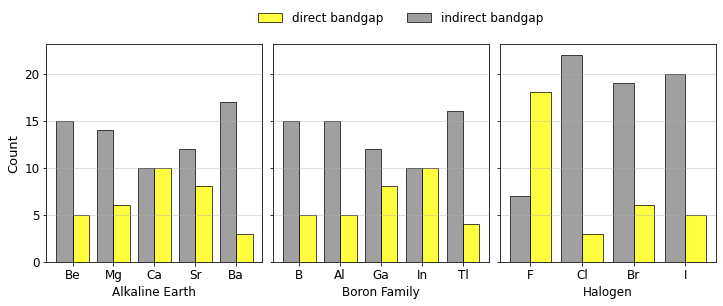

In [ ]:
dados2 = results_df.copy()

dados2['alkaline_earth'] =  pd.Categorical(dados2['A'], ['Be','Mg','Ca','Sr', 'Ba'])
dados2['boron_family'] =  pd.Categorical(dados2['B'], ['B','Al','Ga','In', 'Tl'])
dados2['halogen'] =  pd.Categorical(dados2['C'], ['F','Cl','Br','I'])

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

sns.histplot(x="alkaline_earth",hue="bandgap_direct",
            palette=["grey", "yellow"], linewidth=0.7, ax=axes[0],
            data=dados2, multiple="dodge", shrink=.8, legend=None
           )

sns.histplot(x="boron_family", hue="bandgap_direct",
            palette=["grey", "yellow"], linewidth=0.7, ax=axes[1],
            data=dados2, multiple="dodge", shrink=.8, legend=None
           )

sns.histplot(x="halogen", hue="bandgap_direct",
            palette=["grey", "yellow"], linewidth=0.7, ax=axes[2],
            data=dados2, multiple="dodge", shrink=.8, legend=None
           )

axes[0].grid(axis='y', alpha=0.5)
axes[1].grid(axis='y', alpha=0.5)
axes[2].grid(axis='y', alpha=0.5)

axes[0].set_xlabel('Alkaline Earth',  fontsize=12)
axes[1].set_xlabel('Boron Family',  fontsize=12)
axes[2].set_xlabel('Halogen',  fontsize=12)

axes[0].set_ylabel('Count',  fontsize=13)

axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='minor', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)

plt.subplots_adjust(wspace=0.05)
plt.legend(labels = ['direct bandgap', 'indirect bandgap'],
           bbox_to_anchor =(0.25, 1.20),
           frameon=False, labelspacing=1, fontsize=12, ncol=2)

### 4) **Bandgap as a function of chemical element**:

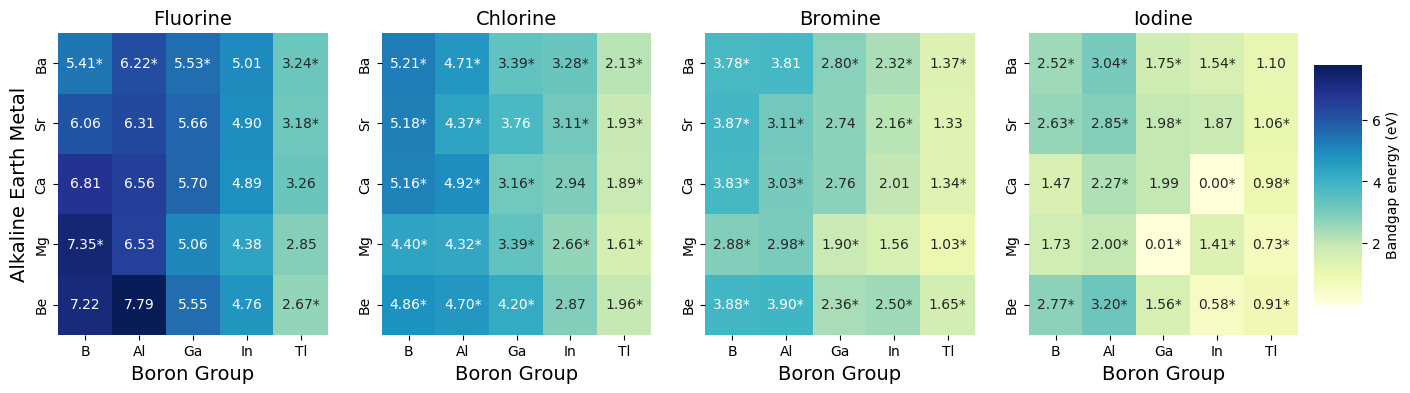

In [ ]:
# Heatmap Bandgap
escalax = ['Be','Mg','Ca','Sr','Ba']
escalay = ['B','Al','Ga','In','Tl']

heatmap_fenergy_F   = np.zeros((len(escalay),len(escalax)))
heatmap_fenergy_Cl  = np.zeros((len(escalay),len(escalax)))
heatmap_fenergy_Br  = np.zeros((len(escalay),len(escalax)))
heatmap_fenergy_I   = np.zeros((len(escalay),len(escalax)))

heatmap_direct_F = np.zeros((len(escalay),len(escalax)), dtype=object)
heatmap_direct_Cl = np.zeros((len(escalay),len(escalax)), dtype=object)
heatmap_direct_Br = np.zeros((len(escalay),len(escalax)), dtype=object)
heatmap_direct_I = np.zeros((len(escalay),len(escalax)), dtype=object)

    
for i in range(0, len(escalax)):
    for j in range(0, len(escalay)):
        dfx = results_df[results_df['A']==escalax[i]]
        dfy = dfx[dfx['B']==escalay[j]]
        
        heatmap_fenergy_F[i][j] = dfy[dfy['C']=='F']['bandgap'].values[0]
        heatmap_fenergy_Cl[i][j] = dfy[dfy['C']=='Cl']['bandgap'].values[0]
        heatmap_fenergy_Br[i][j] = dfy[dfy['C']=='Br']['bandgap'].values[0]
        heatmap_fenergy_I[i][j] = dfy[dfy['C']=='I']['bandgap'].values[0]
        
        if not(dfy[dfy['C']=='F']['bandgap_direct'].values[0]):
            if dfy[dfy['C']=='F']['bandgap'].values[0] == 0:
                heatmap_direct_F[i][j] = ''
            else:
                heatmap_direct_F[i][j] = '*'
        else:
            heatmap_direct_F[i][j] = ''
            
        if not(dfy[dfy['C']=='Cl']['bandgap_direct'].values[0]):
            if dfy[dfy['C']=='Cl']['bandgap'].values[0] == 0:
                heatmap_direct_Cl[i][j] = ''
            else:
                heatmap_direct_Cl[i][j] = '*'
        else:
            heatmap_direct_Cl[i][j] = ''
            
        if not(dfy[dfy['C']=='Br']['bandgap_direct'].values[0]):
            if dfy[dfy['C']=='Br']['bandgap'].values[0] == 0:
                heatmap_direct_Br[i][j] = ''
            else:
                heatmap_direct_Br[i][j] = '*'
        else:
            heatmap_direct_Br[i][j] = ''
            
        if not(dfy[dfy['C']=='I']['bandgap_direct'].values[0]): 
            if dfy[dfy['C']=='I']['bandgap'].values[0] == 0:
                heatmap_direct_I[i][j] = ''
            else:
                heatmap_direct_I[i][j] = '*'
        else:
            heatmap_direct_I[i][j] = ''

            
nomes = ['Fluorine', 'Chlorine', 'Bromine', 'Iodine']
matrizes = [heatmap_fenergy_F, heatmap_fenergy_Cl, heatmap_fenergy_Br, heatmap_fenergy_I]
directs = [heatmap_direct_F, heatmap_direct_Cl, heatmap_direct_Br, heatmap_direct_I]

maior=[]
menor=[]
for mat in matrizes:
    maior.append(np.amax(mat))
    menor.append(np.amin(mat))
    
vmin = min(menor)
vmax = max(maior)

fig, ax = plt.subplots(1,4, figsize=(16,4), dpi=100)
cbar_ax = fig.add_axes([.91,.2,.03,.6])

for i, axis in enumerate(ax):
    
    labels = (np.asarray(["{1:.2f}{0}".format(string, value)
                      for string, value in zip(directs[i].flatten(),
                                               matrizes[i].flatten())])
         ).reshape(len(escalax), len(escalay))
    
    sns.heatmap(matrizes[i], annot=labels, fmt="", 
                linewidths=0.0, ax=axis,
                xticklabels=escalay, yticklabels=escalax,
                cbar=True,
                vmin=vmin,
                vmax=vmax,
                cmap="YlGnBu", #BuPu
                robust=False,
                cbar_ax = cbar_ax,
                cbar_kws={'label': 'Bandgap energy (eV)'})
    axis.invert_yaxis()
    if i==0:
        axis.set_ylabel('Alkaline Earth Metal', fontsize=14)
    axis.set_xlabel('Boron Group', fontsize=14)
    axis.set_title(nomes[i], fontsize=14)

plt.rcParams['font.size'] = 12
#plt.savefig('bandgap1.png')

# Section 5 -  Machine Learning Project

- Predict the bandgap of a semiconductor alloy by traning a ML model using the DFT results above. 
We will have one train set with:
- alloy ID (column `material`)
- its features meaning: 
    - Quantitative features:  
    `cbm`, conduction band maximum

    `vbm`: valence band maximum

    `lattice_a`, `lattice_b`, `lattice_c`: crystal lattice parameters
    
    `lattice_alpha`, `lattice_beta`,	`lattice_gamma`: crystal lattice angles
    - Qualitaitve features:

    `material`: ID name

    `A`, `B`, `C`: elements in the alloy
- the `y`true labels: `bandgap`

### Exploring the Data

In [ ]:
results_df.head()

,material,A,B,C,bandgap,cbm,vbm,bandgap_direct,lattice_a,lattice_b,lattice_c,lattice_alpha,lattice_beta,lattice_gamma
0,BeBF5,Be,B,F,7.215247,4.623167,-2.592080,True,5.137239,5.141555,9.477953,123.430231,56.544091,122.173758
1,BeBCl5,Be,B,Cl,4.864420,1.425657,-3.438763,False,7.790373,7.762067,10.530760,115.351539,64.603085,108.196125
2,BeBBr5,Be,B,Br,3.883992,0.861019,-3.022973,False,8.186414,8.214125,11.804317,116.866052,63.329587,117.455505
3,BeBI5,Be,B,I,2.766870,2.010463,-0.756407,False,8.628103,8.648576,11.983029,115.132217,64.378342,114.868954
4,BeAlF5,Be,Al,F,7.786402,6.512569,-1.273833,True,4.811944,4.811913,7.439838,112.740046,67.273112,98.664274


In [ ]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   material        100 non-null    object 
 1   A               100 non-null    object 
 2   B               100 non-null    object 
 3   C               100 non-null    object 
 4   bandgap         100 non-null    float64
 5   cbm             100 non-null    float64
 6   vbm             100 non-null    float64
 7   bandgap_direct  100 non-null    bool   
 8   lattice_a       100 non-null    float64
 9   lattice_b       100 non-null    float64
 10  lattice_c       100 non-null    float64
 11  lattice_alpha   100 non-null    float64
 12  lattice_beta    100 non-null    float64
 13  lattice_gamma   100 non-null    float64
dtypes: bool(1), float64(9), object(4)
memory usage: 10.4+ KB


In [ ]:
# Verifying NAN values: OK!!!
results_df.isna().sum()

material          0
A                 0
B                 0
C                 0
bandgap           0
cbm               0
vbm               0
bandgap_direct    0
lattice_a         0
lattice_b         0
lattice_c         0
lattice_alpha     0
lattice_beta      0
lattice_gamma     0
dtype: int64

#### Converting string to categories 

One way we can turn all of our data into numbers is by converting them into Pandas categories!

We can check the different datatypes available in Pandas here:
https://pandas.pydata.org/pandas-docs/version/0.22/api.html#data-types-related-functionality

**Make a copy of the original DataFrame**

When manipulating the data, we can always go back to the original

In [ ]:
# Make a copy
df_tmp = results_df.copy() 

In [ ]:
df_tmp.head().T

,0,1,2,3,4
material,BeBF5,BeBCl5,BeBBr5,BeBI5,BeAlF5
A,Be,Be,Be,Be,Be
B,B,B,B,B,Al
C,F,Cl,Br,I,F
bandgap,7.215247,4.86442,3.883992,2.76687,7.786402
cbm,4.623167,1.425657,0.861019,2.010463,6.512569
vbm,-2.59208,-3.438763,-3.022973,-0.756407,-1.273833
bandgap_direct,True,False,False,False,True
lattice_a,5.137239,7.790373,8.186414,8.628103,4.811944
lattice_b,5.141555,7.762067,8.214125,8.648576,4.811913


In [ ]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

material
A
B
C


In [ ]:
df_tmp.select_dtypes("object").columns

Index(['material', 'A', 'B', 'C'], dtype='object')

In [ ]:
# This will turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [ ]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   material        100 non-null    category
 1   A               100 non-null    category
 2   B               100 non-null    category
 3   C               100 non-null    category
 4   bandgap         100 non-null    float64 
 5   cbm             100 non-null    float64 
 6   vbm             100 non-null    float64 
 7   bandgap_direct  100 non-null    bool    
 8   lattice_a       100 non-null    float64 
 9   lattice_b       100 non-null    float64 
 10  lattice_c       100 non-null    float64 
 11  lattice_alpha   100 non-null    float64 
 12  lattice_beta    100 non-null    float64 
 13  lattice_gamma   100 non-null    float64 
dtypes: bool(1), category(4), float64(9)
memory usage: 13.1 KB


In [ ]:
# saves the categories inside a dictionary for later
cat_material = dict(enumerate(df_tmp['material'].cat.categories))
# cat_material

In [ ]:
df_tmp.A.cat.categories

Index(['Ba', 'Be', 'Ca', 'Mg', 'Sr'], dtype='object')

In [ ]:
df_tmp.A.value_counts()

Ba    20
Be    20
Ca    20
Mg    20
Sr    20
Name: A, dtype: int64

In [ ]:
# How to acces the data in the form of numbers?
df_tmp.A.cat.codes

0     1
1     1
2     1
3     1
4     1
     ..
95    0
96    0
97    0
98    0
99    0
Length: 100, dtype: int8

#### Converting categories to numbers

In [ ]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   material        100 non-null    category
 1   A               100 non-null    category
 2   B               100 non-null    category
 3   C               100 non-null    category
 4   bandgap         100 non-null    float64 
 5   cbm             100 non-null    float64 
 6   vbm             100 non-null    float64 
 7   bandgap_direct  100 non-null    bool    
 8   lattice_a       100 non-null    float64 
 9   lattice_b       100 non-null    float64 
 10  lattice_c       100 non-null    float64 
 11  lattice_alpha   100 non-null    float64 
 12  lattice_beta    100 non-null    float64 
 13  lattice_gamma   100 non-null    float64 
dtypes: bool(1), category(4), float64(9)
memory usage: 13.1 KB


In [ ]:
df_tmp.head()

,material,A,B,C,bandgap,cbm,vbm,bandgap_direct,lattice_a,lattice_b,lattice_c,lattice_alpha,lattice_beta,lattice_gamma
0,BeBF5,Be,B,F,7.215247,4.623167,-2.592080,True,5.137239,5.141555,9.477953,123.430231,56.544091,122.173758
1,BeBCl5,Be,B,Cl,4.864420,1.425657,-3.438763,False,7.790373,7.762067,10.530760,115.351539,64.603085,108.196125
2,BeBBr5,Be,B,Br,3.883992,0.861019,-3.022973,False,8.186414,8.214125,11.804317,116.866052,63.329587,117.455505
3,BeBI5,Be,B,I,2.766870,2.010463,-0.756407,False,8.628103,8.648576,11.983029,115.132217,64.378342,114.868954
4,BeAlF5,Be,Al,F,7.786402,6.512569,-1.273833,True,4.811944,4.811913,7.439838,112.740046,67.273112,98.664274


In [ ]:
# Turns categorical varibles into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_tmp[label] = pd.Categorical(content).codes +1 # so all numbers are positive

In [ ]:
df_tmp.info() # they are all bool, float or int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   material        100 non-null    int8   
 1   A               100 non-null    int8   
 2   B               100 non-null    int8   
 3   C               100 non-null    int8   
 4   bandgap         100 non-null    float64
 5   cbm             100 non-null    float64
 6   vbm             100 non-null    float64
 7   bandgap_direct  100 non-null    bool   
 8   lattice_a       100 non-null    float64
 9   lattice_b       100 non-null    float64
 10  lattice_c       100 non-null    float64
 11  lattice_alpha   100 non-null    float64
 12  lattice_beta    100 non-null    float64
 13  lattice_gamma   100 non-null    float64
dtypes: bool(1), float64(9), int8(4)
memory usage: 7.6 KB


#### Splitting data into X and y (features and labels)

In [ ]:
# Split data into X and y (features and labels)
X, y = df_tmp.drop("bandgap", axis=1), df_tmp["bandgap"]

X.shape, y.shape

((100, 13), (100,))

#### Splitting X and y into train and test sets 

In [ ]:
# Creating a test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

Train set: (80, 13)
Test set: (20, 13)


### Creating an **evaluation** function
Lets define a quantitative goal for our model: **$R^2$ > 0.90**
- **MSE** = it amplifys larger differences because of the squaring of the differences between predicted values and actual values (amplifiys outliers and removes negatives, the best value is 0.0)
- **RMSE** = returns the error in its initial scale, more comprehensible! (the best value is 0.0)
- **MAE** = how far off each of the model's predictions are away from the average (gives an idea of how worng the predictions are, the best value is 0.0.)
- **RMSLE** = mainly used when predictions have large deviations (can be from 0 to millions, the best being 0.0)
- **R^2** = compares model's preedictions to the mean of the target (can be negative, the best value is 1)

In [ ]:
# Lets create an evaluation function that is going to contain multiple evalutation metrics
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_squared_error 

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error betweeen predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create fucntion to vealuate model on a few different levels
def show_scores(model):
  """
  Given a model, displays multiple evaluation functions for the train set and the test set.
  Evaluation functions present are: MAE, RMSLE, R^2
  """
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)
  scores = {"Training MAE":   mean_absolute_error(y_train, train_preds),
            "Test MAE":      mean_absolute_error(y_test, test_preds),
            "Training MSE":   mean_squared_error(y_train, train_preds),
            "Test MSE":      mean_squared_error(y_test, test_preds),
            "Training RMSE":   mean_squared_error(y_train, train_preds, squared=True),
            "Test RMSE":      mean_squared_error(y_test, test_preds, squared=True),
            "Training RMSLE": rmsle(y_train, train_preds),
            "Test RMSLE":    rmsle(y_test, test_preds),
            "Training R^2":   r2_score(y_train, train_preds),
            "Test R^2":      r2_score(y_test, test_preds)}
  return scores

### Simple model

In [ ]:
# Setting a random seed
np.random.seed(1992)

Lets start with a simple `RandomForestRegressor`

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
simple_model = RandomForestRegressor(n_jobs=-1,
                              max_samples=10,
                              random_state=11)

In [ ]:
simple_model.fit(X_train, y_train)

RandomForestRegressor(max_samples=10, n_jobs=-1, random_state=11)

In [ ]:
simple_model.predict(X_test)

array([2.88605462, 2.56254314, 4.51883273, 2.71167844, 2.75804804,
       3.10485569, 3.24818841, 1.99277762, 4.73239565, 4.09779295,
       2.6921138 , 2.76331644, 2.44426315, 4.47151166, 4.13374999,
       2.34756588, 3.44773603, 5.25706138, 3.0347768 , 4.48678465])

In [ ]:
simple_model.score(X_test, y_test)

0.6997995910379771

In [ ]:
show_scores(simple_model)

{'Training MAE': 0.7878681312499999,
 'Test MAE': 0.8387249794999999,
 'Training MSE': 0.9841891349773073,
 'Test MSE': 0.9305832113448158,
 'Training RMSE': 0.9841891349773073,
 'Test RMSE': 0.9305832113448158,
 'Training RMSLE': 0.3093549498415341,
 'Test RMSLE': 0.2822265041009953,
 'Training R^2': 0.6739074682407269,
 'Test R^2': 0.6997995910379771}

### Modeling using Cross Validation

In [ ]:
# We obtain cv=3 scores for each of the pieces of CV data
from sklearn.model_selection import cross_val_score

CV_analysis = cross_val_score(RandomForestRegressor(n_estimators=100, random_state=11), 
                              X_train, 
                              y_train, 
                              cv=3, 
                              scoring="r2"
                              )

print('each score for each piece of CV is ', CV_analysis)

each score for each piece of CV is  [0.51392345 0.84941138 0.89103151]


In [ ]:
#then I have to do the average of these 5 scores, to evaluate if
#the n_estimators=100 is good or not

print('the average for all scores of each piece of CV is ', CV_analysis.mean())

the average for all scores of each piece of CV is  0.7514554470290303


Lets use `validation_curve` to analyse multiple `n_estimators`!

In [ ]:
#VALIDATION CURVE!

from sklearn.model_selection import validation_curve

the averages scores for each k are :  [0.62309606 0.71650914 0.71551263 0.71673578 0.6945008  0.73478173
 0.76425287 0.76847503 0.76390591 0.7756108  0.76167355 0.75699696
 0.74680594 0.74156757 0.742309   0.7511955  0.74487245 0.75430514
 0.76384372 0.75135368 0.75913339 0.7556942  0.7528925  0.74665967
 0.73826659 0.73247601 0.7265817  0.72743421 0.72297509 0.73205018
 0.73701259 0.73891117 0.7462159  0.74902101 0.74257435 0.74597867
 0.74179934 0.743645   0.73912103 0.73542367 0.7368754  0.73827242
 0.74243298 0.74081757 0.73704959 0.73942701 0.73841704 0.74431963
 0.74385816 0.74088543 0.74387125 0.74619744 0.74823027 0.74720629
 0.74496208 0.74358735 0.74563559 0.74243427 0.74386142 0.74263707
 0.74146843 0.74200757 0.74184602 0.74348725 0.74315737 0.74383862
 0.74320989 0.74694603 0.74754724 0.74779816 0.74491306 0.74496812
 0.74667403 0.74733794 0.74934765 0.75134874 0.75284018 0.75255244
 0.7537932  0.75404151 0.75409799 0.75292682 0.75277775 0.75386421
 0.75674749 0.7573071  0

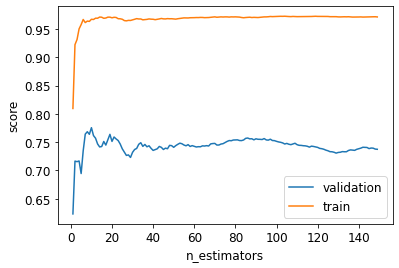

In [ ]:
model = RandomForestRegressor(random_state=11)
val_score_dic = {}
k = np.arange(1,150)

train_score, val_score = validation_curve(model, 
                                          X_train, 
                                          y_train, 
                                          param_name="n_estimators", 
                                          param_range=k, 
                                          cv=3) #cv is the number 
                                                #of cross validations

# saving each val_score.mean result into a dic with its key being the n_estimators value
for key, value in zip(k, val_score.mean(axis=1)):
  val_score_dic[key] = value

#all the scores for all pieces of CV for each k, so I have 49 lines
# print(val_score)    

#now I can do the average of each line, to average all the scores of the 
#pieces of CV to have a score averaged value for each k
print('the averages scores for each k are : ', val_score.mean(axis=1))
    
plt.plot(k, val_score.mean(axis=1), label = "validation")

plt.plot(k, train_score.mean(axis=1), label = 'train')

plt.ylabel('score')
plt.xlabel('n_estimators')
plt.legend()

In [ ]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 11,
 'verbose': 0,
 'warm_start': False}

In [ ]:
val_score_dic # n_estimators : val_score.mean

{1: 0.6230960562818569,
 2: 0.7165091394475193,
 3: 0.7155126312422128,
 4: 0.7167357821104936,
 5: 0.6945007956137007,
 6: 0.7347817266360844,
 7: 0.7642528672456997,
 8: 0.768475029567286,
 9: 0.7639059078167193,
 10: 0.7756108043931037,
 11: 0.7616735481554722,
 12: 0.7569969580293917,
 13: 0.7468059370419775,
 14: 0.7415675668871513,
 15: 0.7423089951436226,
 16: 0.7511954990371398,
 17: 0.7448724534780723,
 18: 0.7543051367622738,
 19: 0.7638437211058267,
 20: 0.7513536816116749,
 21: 0.7591333941976764,
 22: 0.7556941976682081,
 23: 0.7528924982017248,
 24: 0.7466596677046596,
 25: 0.7382665937608955,
 26: 0.7324760102177196,
 27: 0.7265817001959972,
 28: 0.7274342055872621,
 29: 0.7229750913483398,
 30: 0.7320501789923007,
 31: 0.7370125949756928,
 32: 0.7389111713317652,
 33: 0.7462158963364677,
 34: 0.7490210110265433,
 35: 0.7425743479034796,
 36: 0.7459786671335156,
 37: 0.7417993364659828,
 38: 0.7436450018896824,
 39: 0.7391210254544623,
 40: 0.7354236716010188,
 41: 0.736

In [ ]:
# printing the n_estimators number with the highest score
n_estimator_CV_max = list(val_score_dic.values()).index(max(val_score_dic.values()))+1 # finds the index not the key
score_CV_max = max(val_score_dic.values())

print('n_estimators', n_estimator_CV_max, 'with the max score', score_CV_max)

n_estimators 10 with the max score 0.7756108043931037


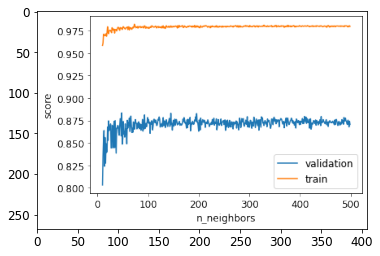

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('/content/drive/MyDrive/results_bs/n_est_500.png')
plt.imshow(img)

The model is overfitting the train data (learning its patterns too well)! But at least its learning!

In [ ]:
model_best_CV = RandomForestRegressor(n_estimators=10, random_state=11)
CV_analysis_best = cross_val_score(model_best_CV, 
                              X_train, 
                              y_train, 
                              cv=3, 
                              scoring="r2")

print('each score for each piece of CV is ', CV_analysis_best.mean(axis=0))

each score for each piece of CV is  0.7756108043931037


### Expanding the search for params with GridSearchCV 

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'n_estimators': np.arange(1,30),
              'max_depth': [int(x) for x in np.linspace(4, 110, num=11)],
              'max_features': ['auto', 'sqrt', 'log2'],
              'bootstrap': [True, False]
                }

grid = GridSearchCV(RandomForestRegressor(random_state=11), param_grid, cv=3)

grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=11),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [4, 14, 25, 35, 46, 57, 67, 78, 88, 99,
                                       110],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [ ]:
grid.best_score_

0.8217090308211357

In [ ]:
from pprint import pprint

print('Best GridSearchCV score is :', grid.best_score_, '\n')
print('Best GridSearchCV params are :')
pprint(grid.best_params_)


print('\n\nBest CV score is :', score_CV_max, 'for n_estimators=', n_estimator_CV_max)
print('\nBest CV params were :')
pprint(model.get_params())


Best GridSearchCV score is : 0.8217090308211357 

Best GridSearchCV params are :
{'bootstrap': False,
 'max_depth': 14,
 'max_features': 'sqrt',
 'n_estimators': 14}


Best CV score is : 0.7756108043931037 for n_estimators= 10

Best CV params were :
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 11,
 'verbose': 0,
 'warm_start': False}


### Expanding the search for params with RandomizedearchCV 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestREgressor hyperparameters
rf_grid = {"n_estimators":      np.arange(10, 100, 10),
           "max_depth":         [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf":  np.arange(1, 20, 2),
           "max_features":      [0.5, 1, "sqrt", "auto"]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [ ]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 50,
 'min_samples_split': 8,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 10}

In [ ]:
rs_model.best_score_

0.6771983130921561

### Training the ideal model

In [ ]:
# Most ideal hyperparameters (from GridSearchCV)
ideal_model = RandomForestRegressor(n_estimators=14,
                                    max_depth=14,
                                    max_features='sqrt',
                                    random_state=11)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, max_features='sqrt', n_estimators=14,
                      random_state=11)

In [ ]:
ideal_model.score(X_test, y_test)

0.881571836455233

In [ ]:
show_scores(ideal_model)

{'Training MAE': 0.2177953214285715,
 'Test MAE': 0.4689513392857142,
 'Training MSE': 0.08531431285999977,
 'Test MSE': 0.36711229383801497,
 'Training RMSE': 0.08531431285999977,
 'Test RMSE': 0.36711229383801497,
 'Training RMSLE': 0.11329656612492625,
 'Test RMSLE': 0.2065165801958769,
 'Training R^2': 0.9717327094080738,
 'Test R^2': 0.881571836455233}

### Lets analyse if more data would be usefull with the **Learning Curve**:

In [ ]:
from sklearn.model_selection import learning_curve

[ 6 12 19 25 32 38 44 51 57 64]


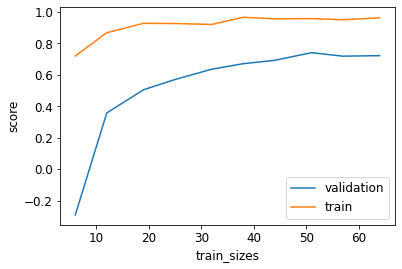

In [ ]:
N, train_score, val_score = learning_curve(ideal_model, X_train, y_train, 
               train_sizes = np.linspace(0.1, 1.0, 10),
                                         cv=5)

print(N)
plt.plot(N, val_score.mean(axis=1), label = "validation")
plt.plot(N, train_score.mean(axis=1), label = 'train')

plt.ylabel('score')
plt.xlabel('train_sizes')
plt.legend()

**conclusion**: more data does not seem to increase the learning curve, so more data might not imporve the model that much.

### Saving the model

In [ ]:
from joblib import dump, load # saving and loading model

import datetime # track each exp with date and time

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join('drive/MyDrive/results_bs/models',
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  model_path = modeldir + "-" + suffix + ".h5" # save the format of model
  print(f"Saving model to: {model_path}...")
  dump(model, model_path)
  return model_path

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specific path.
  """
  print(f"Loading saved model from: {model_path}...")
  model = load(model_path)
  return model

In [ ]:
# Saving the CV model
# save_model(model_best_CV, suffix='best_CV')

# Saving the GridSearchCV model
# save_model(grid, suffix="best_Grid")

Saving model to: drive/MyDrive/results_bs/models/20230206-10091675678179-best_CV.h5...
Saving model to: drive/MyDrive/results_bs/models/20230206-10091675678179-best_Grid.h5...


'drive/MyDrive/results_bs/models/20230206-10091675678179-best_Grid.h5'

In [ ]:
# Saving the ideal model coming from the GridSearchCV hyperparams tunning
# save_model(ideal_model, suffix="ideal_model")

Saving model to: drive/MyDrive/results_bs/models/20230206-13471675691269-ideal_model.h5...


'drive/MyDrive/results_bs/models/20230206-13471675691269-ideal_model.h5'

In [ ]:
# loading back the CV model
model_best_CV_loaded = load_model("drive/MyDrive/results_bs/models/20230206-10081675678097-best_CV.h5")

# loading back the GridSearchCV model
model_best_GridCV_loaded = load_model("drive/MyDrive/results_bs/models/20230206-10091675678179-best_Grid.h5")


Loading saved model from: drive/MyDrive/results_bs/models/20230206-10081675678097-best_CV.h5...
Loading saved model from: drive/MyDrive/results_bs/models/20230206-10091675678179-best_Grid.h5...


In [ ]:
# Loading the ideal amodel
ideal_model_loaded = load_model("drive/MyDrive/results_bs/models/20230206-13471675691269-ideal_model.h5")

Loading saved model from: drive/MyDrive/results_bs/models/20230206-13471675691269-ideal_model.h5...


In [ ]:
# Evaluating back the CV model to check if loaded model if sucessful
CV_analysis_best_loaded = cross_val_score(model_best_CV_loaded, 
                              X_train, 
                              y_train, 
                              cv=3, 
                              scoring="r2")

print('each score for each piece of CV is ', CV_analysis_best_loaded.mean(axis=0))

each score for each piece of CV is  0.7756108043931037


In [ ]:
# Evaluating back the GridCV to check if loaded is sucessful
model_best_GridCV_loaded.best_score_

0.8217090308211357

In [ ]:
# Evaluating the ideal model
ideal_model.score(X_test, y_test)

0.881571836455233

### Lets make predictions on the test set using the GridSearchCV model

In [ ]:
y_preds = ideal_model_loaded.predict(X_test)
y_preds

array([2.01011757, 2.75298557, 5.351245  , 1.99395543, 2.39597907,
       3.052043  , 3.00869929, 1.77944129, 5.66006071, 3.23066243,
       1.99403171, 2.56740557, 2.23998643, 5.49806179, 4.35719393,
       1.94153707, 4.47843464, 6.61901736, 3.25271079, 4.36773271])

In [ ]:
X_test.head()

,material,A,B,C,cbm,vbm,bandgap_direct,lattice_a,lattice_b,lattice_c,lattice_alpha,lattice_beta,lattice_gamma
35,76,4,4,4,3.412784,1.998913,False,7.592095,7.597546,11.317734,111.177519,68.863766,100.560450
95,16,1,4,4,2.521759,0.984261,False,8.577981,8.540201,14.608898,122.768713,57.383927,123.927723
12,35,2,4,3,2.670963,-2.089296,True,5.212960,5.211415,8.438576,113.879620,66.108932,99.538760
71,92,5,3,4,3.124131,1.142105,False,7.857866,7.856972,12.119720,113.238619,66.795954,102.248036
34,73,4,4,1,1.601263,0.040939,True,7.145060,7.068968,11.622900,116.480182,63.090629,113.556545


### Lets visualize the predictions

In [ ]:
# Making a copy of the X_test
dados2 = X_test.copy()

# Adding the true and pred labels
dados2["true_labels"] = y_test
dados2["pred_labels"] = y_preds

In [ ]:
# Transforming back to categorical pandas
dados2['material_reversed'] = pd.Series(dados2['material'].map(cat_material))
type(dados2)

pandas.core.frame.DataFrame

In [ ]:
dados2.head()

,material,A,B,C,cbm,vbm,bandgap_direct,lattice_a,lattice_b,lattice_c,lattice_alpha,lattice_beta,lattice_gamma,true_labels,pred_labels,material_reversed
35,76,4,4,4,3.412784,1.998913,False,7.592095,7.597546,11.317734,111.177519,68.863766,100.560450,1.413871,2.010118,MgTlBr5
95,16,1,4,4,2.521759,0.984261,False,8.577981,8.540201,14.608898,122.768713,57.383927,123.927723,1.537498,2.752986,BaTlBr5
12,35,2,4,3,2.670963,-2.089296,True,5.212960,5.211415,8.438576,113.879620,66.108932,99.538760,4.760259,5.351245,BeInI5
71,92,5,3,4,3.124131,1.142105,False,7.857866,7.856972,12.119720,113.238619,66.795954,102.248036,1.982026,1.993955,SrInBr5
34,73,4,4,1,1.601263,0.040939,True,7.145060,7.068968,11.622900,116.480182,63.090629,113.556545,1.560324,2.395979,MgInCl5


In [ ]:
# for fixing ticks
import matplotlib.ticker

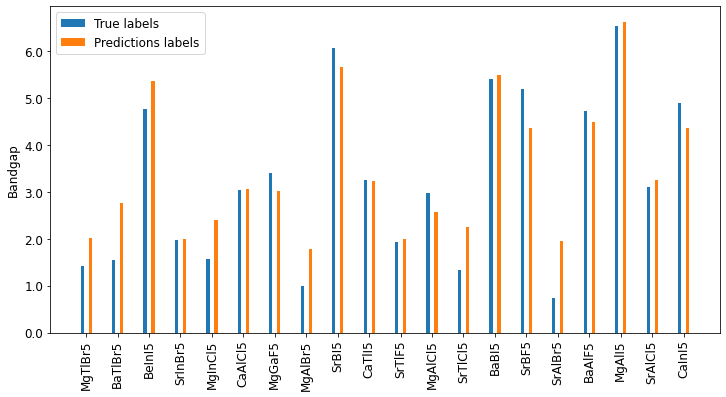

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

X_axis = np.linspace(1, 150, len(dados2['material_reversed']))

plt.bar(X_axis - 1, dados2['true_labels'], label="True labels")
plt.bar(X_axis + 1, dados2['pred_labels'], label="Predictions labels")

plt.ylabel("Bandgap")
plt.legend()

formatter = matplotlib.ticker.StrMethodFormatter("{x:.1f}")
plt.gca().yaxis.set_major_formatter(formatter)

_ = plt.xticks(X_axis, dados2['material_reversed'], rotation=90)

### Lets try to improve the model using **Feature Importance**

In [ ]:
ideal_model.feature_importances_ # each column has its value of "importance"

array([0.0423597 , 0.00414282, 0.05971324, 0.07869415, 0.17233741,
       0.17828435, 0.0158687 , 0.20897759, 0.06346184, 0.06134743,
       0.02263127, 0.05342813, 0.03875337])

In [ ]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    
    # Plot the df
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set(xlabel="Features Importances", ylabel="Features")
    ax.invert_yaxis()

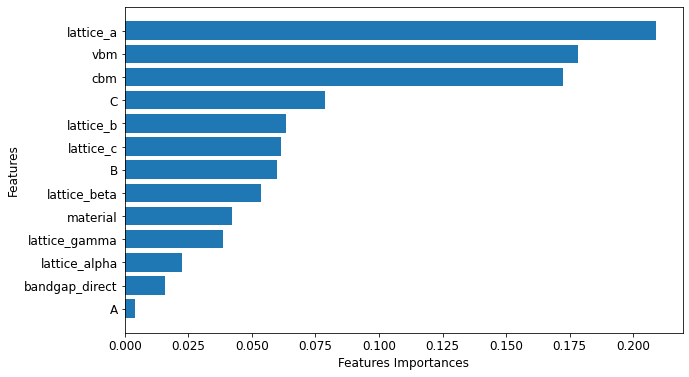

In [ ]:
plot_features(X_train.columns, ideal_model.feature_importances_)

**Conclusion**: 
- it is stricking that the compound atoms A, B, C do not have the same feature importance. C has a 70 times bigger than A! C is about 12% higher than B.  
- in the same observation, the lattice parameters a, b, c do not have the same importance, the lattice param abeing 3.5 times higher improtance than the other two
- the conduction and vallence band maxima are , hovewer, in the top 3 of features with the highest importances. It makes sense since the target label is the bandgap, being physically intrincic correlated to the cbm and vbm.

- Lets selected only the best features, meaning with a threshold of 5% importance, which gives the first 8 features!

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif #ANOVA!

In [ ]:
# creates a pipeline with the feature selection and the model
model_feat = make_pipeline(SelectKBest(f_classif, k=8),
                      RandomForestRegressor(random_state=11))


# Fit the ideal model
model_feat.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)


Pipeline(steps=[('selectkbest', SelectKBest(k=8)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=11))])

In [ ]:
model_feat.score(X_test, y_test)

0.771357278061749

In [ ]:
show_scores(model_feat)

{'Training MAE': 0.34471131587500015,
 'Test MAE': 0.7224015560000009,
 'Training MSE': 0.18583563982559642,
 'Test MSE': 0.7087634529466419,
 'Training RMSE': 0.18583563982559642,
 'Test RMSE': 0.7087634529466419,
 'Training RMSLE': 0.14808904320722233,
 'Test RMSLE': 0.2579384749873125,
 'Training R^2': 0.9384268611304774,
 'Test R^2': 0.771357278061749}

**conclusion**: it is worth than with all the features, so lets try something else

### Lets improve the model itself: **CatBoostRegressor**

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.0 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
# Building a simple CatBoostRefressor model to start
cat_boost = CatBoostRegressor(random_state=11)

# fit the model on train set
cat_boost.fit(X_train, y_train)

Learning rate set to 0.027471
0:	learn: 1.7151140	total: 1.77ms	remaining: 1.77s
1:	learn: 1.6985993	total: 2.85ms	remaining: 1.42s
2:	learn: 1.6733865	total: 3.47ms	remaining: 1.15s
3:	learn: 1.6561599	total: 4.1ms	remaining: 1.02s
4:	learn: 1.6337926	total: 5.23ms	remaining: 1.04s
5:	learn: 1.6155210	total: 6.37ms	remaining: 1.06s
6:	learn: 1.5915004	total: 7.02ms	remaining: 995ms
7:	learn: 1.5695321	total: 8.31ms	remaining: 1.03s
8:	learn: 1.5468056	total: 9.22ms	remaining: 1.01s
9:	learn: 1.5237144	total: 10.4ms	remaining: 1.03s
10:	learn: 1.5052419	total: 11.6ms	remaining: 1.04s
11:	learn: 1.4873451	total: 12.8ms	remaining: 1.05s
12:	learn: 1.4678197	total: 13.9ms	remaining: 1.05s
13:	learn: 1.4512174	total: 15ms	remaining: 1.06s
14:	learn: 1.4391523	total: 16.3ms	remaining: 1.07s
15:	learn: 1.4211541	total: 17.5ms	remaining: 1.07s
16:	learn: 1.4034333	total: 18.9ms	remaining: 1.09s
17:	learn: 1.3837257	total: 20ms	remaining: 1.09s
18:	learn: 1.3662606	total: 21ms	remaining: 1.08s

In [ ]:
# make predictions on train set
cat_boost.score(X_test, y_test) # much better :D

0.948648110178942

In [ ]:
# Making predictions
y_preds_catboost = cat_boost.predict(X_test)

In [ ]:
save_model(cat_boost, suffix="cat_boost")

Saving model to: drive/MyDrive/results_bs/models/20230206-15211675696885-cat_boost.h5...


'drive/MyDrive/results_bs/models/20230206-15211675696885-cat_boost.h5'

In [ ]:
cat_boost_loaded = load_model("drive/MyDrive/results_bs/models/20230206-15211675696885-cat_boost.h5")

Loading saved model from: drive/MyDrive/results_bs/models/20230206-15211675696885-cat_boost.h5...


In [ ]:
cat_boost_loaded.score(X_test, y_test)

0.948648110178942

In [ ]:
cat_boost_loaded.get_params()

{'loss_function': 'RMSE', 'random_state': 11}

In [ ]:
show_scores(cat_boost_loaded)

{'Training MAE': 0.0070764162408213215,
 'Test MAE': 0.3297638665458271,
 'Training MSE': 7.573901114306359e-05,
 'Test MSE': 0.1591843485607998,
 'Training RMSE': 7.573901114306359e-05,
 'Test RMSE': 0.1591843485607998,
 'Training RMSLE': 0.0023095458629870673,
 'Test RMSLE': 0.1339945845389533,
 'Training R^2': 0.9999749053052723,
 'Test R^2': 0.948648110178942}

### Tunning the CatBoost hyperparams with GridSearchCV

In [ ]:
# Different hyperparams for our CatBoostRegressor Model
catboost_grid = {"iterations": np.arange(2, 30),
                 "learning_rate": [0.1, 0.5, 1.0],
                 "depth": [1, 2, 3]}

# Setup grid hyperparams search for CatBoostRegressor
gs_catboost = GridSearchCV(CatBoostRegressor(random_state=11),
                         param_grid=catboost_grid,
                         cv=5,
                         verbose=True)

# Fit grid hyperparm search model
gs_catboost.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
7:	learn: 0.3023385	total: 3.99ms	remaining: 2.99ms
8:	learn: 0.2602785	total: 4.24ms	remaining: 2.36ms
9:	learn: 0.2460603	total: 4.5ms	remaining: 1.8ms
10:	learn: 0.2167235	total: 4.74ms	remaining: 1.29ms
11:	learn: 0.1872948	total: 4.99ms	remaining: 830us
12:	learn: 0.1786812	total: 5.45ms	remaining: 419us
13:	learn: 0.1572312	total: 5.95ms	remaining: 0us
0:	learn: 1.1244324	total: 334us	remaining: 4.35ms
1:	learn: 0.6797916	total: 625us	remaining: 3.75ms
2:	learn: 0.5567396	total: 912us	remaining: 3.35ms
3:	learn: 0.5206790	total: 1.18ms	remaining: 2.95ms
4:	learn: 0.4540456	total: 1.42ms	remaining: 2.56ms
5:	learn: 0.4048546	total: 1.9ms	remaining: 2.53ms
6:	learn: 0.3871298	total: 2.38ms	remaining: 2.38ms
7:	learn: 0.3562736	total: 3.24ms	remaining: 2.43ms
8:	learn: 0.3122219	total: 3.82ms	remaining: 2.12ms
9:	learn: 0.2730641	total: 4.06ms	remaining: 1.62ms
10:	learn: 0.2396295	total: 4.3ms	remaining: 1.17ms
11:	learn: 0.2127848

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f56f4065a30>,
             param_grid={'depth': [1, 2, 3],
                         'iterations': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'learning_rate': [0.1, 0.5, 1.0]},
             verbose=True)

In [ ]:
gs_catboost.score(X_test, y_test)

0.9483209843899858

In [ ]:
gs_catboost.best_params_

{'depth': 3, 'iterations': 29, 'learning_rate': 0.5}

In [ ]:
# Building a simple CatBoostRefressor model to start
cat_boost_best = CatBoostRegressor(random_state=11, depth=3, iterations=29, learning_rate=0.5)

# fit the model on train set
cat_boost_best.fit(X_train, y_train)

show_scores(cat_boost_best)

0:	learn: 1.3760325	total: 429us	remaining: 12ms
1:	learn: 1.1408001	total: 773us	remaining: 10.4ms
2:	learn: 0.9428294	total: 1.06ms	remaining: 9.2ms
3:	learn: 0.7582597	total: 1.63ms	remaining: 10.2ms
4:	learn: 0.6421111	total: 2.17ms	remaining: 10.4ms
5:	learn: 0.5503270	total: 2.68ms	remaining: 10.3ms
6:	learn: 0.5025827	total: 3.18ms	remaining: 10ms
7:	learn: 0.4542341	total: 3.88ms	remaining: 10.2ms
8:	learn: 0.4224525	total: 4.16ms	remaining: 9.24ms
9:	learn: 0.3698355	total: 4.42ms	remaining: 8.41ms
10:	learn: 0.3317849	total: 4.96ms	remaining: 8.11ms
11:	learn: 0.3218210	total: 5.46ms	remaining: 7.74ms
12:	learn: 0.3139776	total: 6.03ms	remaining: 7.42ms
13:	learn: 0.3050542	total: 6.55ms	remaining: 7.01ms
14:	learn: 0.2980967	total: 7.05ms	remaining: 6.58ms
15:	learn: 0.2764519	total: 7.58ms	remaining: 6.16ms
16:	learn: 0.2663666	total: 8.1ms	remaining: 5.72ms
17:	learn: 0.2480076	total: 8.65ms	remaining: 5.29ms
18:	learn: 0.2301630	total: 9.27ms	remaining: 4.88ms
19:	learn: 

{'Training MAE': 0.11275996322599977,
 'Test MAE': 0.3338398158949548,
 'Training MSE': 0.01973447129880922,
 'Test MSE': 0.16019839703679353,
 'Training RMSE': 0.01973447129880922,
 'Test RMSE': 0.16019839703679353,
 'Training RMSLE': 0.03910427904795962,
 'Test RMSLE': 0.10381562608915425,
 'Training R^2': 0.9934613546522155,
 'Test R^2': 0.9483209843899858}

In [ ]:
save_model(cat_boost_best, suffix="cat_boost_best")

Saving model to: drive/MyDrive/results_bs/models/20230206-15321675697521-cat_boost_best.h5...


'drive/MyDrive/results_bs/models/20230206-15321675697521-cat_boost_best.h5'

### Visualizing the GridSearCV evolution with CatBoost

In [ ]:
# Lets plot the results of the GridSearch using seaborn's lineplot
# Lets first transform the cv_results from GridSearchCV into DataFrame to better manipulation
cv_results = pd.DataFrame(gs_catboost.cv_results_)

# Splits the dict contained in each params row into 3 other columns
cv_results[['depth',
          'iterations',
          'learning_rate']] = cv_results.params.apply(pd.Series)

# Drops the old params column
cv_results = cv_results.drop('params', axis=1)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_learning_rate,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,depth,iterations,learning_rate
0,0.044126,0.007484,0.003913,0.001716,1,2,0.1,0.131567,0.092085,0.085775,0.050859,0.108729,0.093803,0.026685,252,1.0,2.0,0.1
1,0.047332,0.002784,0.006743,0.001851,1,2,0.5,0.495735,0.435404,0.308137,0.193603,0.411432,0.368862,0.106527,229,1.0,2.0,0.5
2,0.054733,0.008166,0.005643,0.001916,1,2,1.0,0.601036,0.613309,0.354062,0.174028,0.458520,0.440191,0.163974,213,1.0,2.0,1.0
3,0.051647,0.002415,0.008006,0.003795,1,3,0.1,0.174296,0.150795,0.117290,0.098258,0.149563,0.138040,0.026919,249,1.0,3.0,0.1
4,0.053824,0.011571,0.005675,0.001762,1,3,0.5,0.541556,0.491595,0.316326,0.296927,0.443971,0.418075,0.096284,218,1.0,3.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.049287,0.004597,0.004661,0.002949,3,28,0.5,0.918810,0.890026,0.848943,0.893764,0.825808,0.875470,0.033451,2,3.0,28.0,0.5
248,0.055847,0.004520,0.002924,0.000832,3,28,1.0,0.865943,0.853722,0.637705,0.735355,0.570294,0.732604,0.116453,105,3.0,28.0,1.0
249,0.054563,0.004028,0.002588,0.000638,3,29,0.1,0.825794,0.802413,0.741007,0.757755,0.745695,0.774533,0.033592,56,3.0,29.0,0.1
250,0.053793,0.004997,0.002123,0.000105,3,29,0.5,0.920035,0.890796,0.853151,0.897759,0.825591,0.877466,0.033716,1,3.0,29.0,0.5


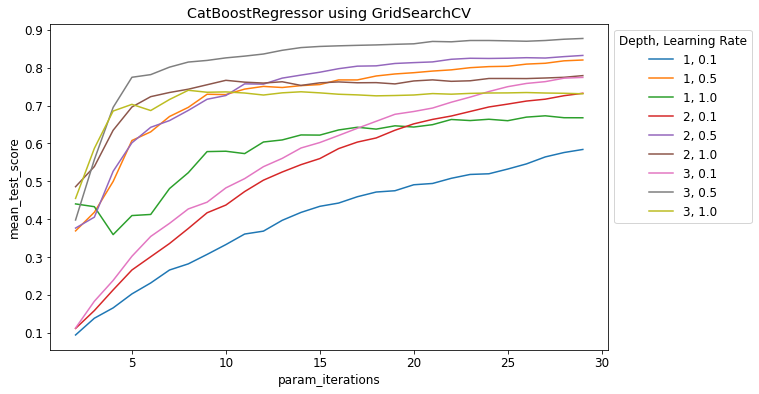

In [ ]:
# Lets try to improve the graph using a pdSeries for the hue parameter
hue = cv_results[["param_depth", "param_learning_rate"]].apply(
    lambda row: f"{row.param_depth}, {row.param_learning_rate}", axis=1)

plt.subplots(figsize=(10, 6))

# Plotting the final data
sns.lineplot(data=cv_results, x="param_iterations", y="mean_test_score", 
             hue=hue).set(title='CatBoostRegressor using GridSearchCV')
plt.legend(bbox_to_anchor=(1, 1), title='Depth, Learning Rate', title_fontsize=12)


### Trying another Boosting model: **XGBoostRegressor**
-more info here: https://xgboost.readthedocs.io/en/stable/get_started.html

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from xgboost import XGBRegressor 

In [ ]:
# Building a simple CatBoostRefressor model to start
xg_boost = XGBRegressor(random_state=11)

# fit the model on train set
xg_boost.fit(X_train, y_train)

# make predictions on train set
xg_boost.score(X_test, y_test) # much better :D

[15:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9377454531305419

In [ ]:
show_scores(xg_boost)

{'Training MAE': 0.040737687184238425,
 'Test MAE': 0.3610572703269959,
 'Training MSE': 0.002623851316857622,
 'Test MSE': 0.19298120327985804,
 'Training RMSE': 0.002623851316857622,
 'Test RMSE': 0.19298120327985804,
 'Training RMSLE': 0.014523510151437338,
 'Test RMSLE': 0.14097587999252686,
 'Training R^2': 0.9991306362888331,
 'Test R^2': 0.9377454531305419}

In [ ]:
save_model(xg_boost, suffix="xg_boost")

Saving model to: drive/MyDrive/results_bs/models/20230206-15401675698007-xg_boost.h5...


'drive/MyDrive/results_bs/models/20230206-15401675698007-xg_boost.h5'

### Hypertunning XGBoostRegressor with RandomizedSearchCV

In [ ]:
# Different hyperparams for our XGBRegressor Model
xgboost_grid = {"n_estimators": np.arange(2, 30),
                "learning_rate": [0.1, 0.5, 1.0],
                "max_depth": [2, 3, 4]}

# Setup grid hyperparams search for CatBoostRegressor
rs_xgboost = RandomizedSearchCV(XGBRegressor(random_state=11),
                         param_distributions=xgboost_grid,
                         cv=5,
                         verbose=True)

# Fit grid hyperparm search model
rs_xgboost.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[15:44:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:58] WARNING: /workspace/src/objective/regre

RandomizedSearchCV(cv=5, estimator=XGBRegressor(random_state=11),
                   param_distributions={'learning_rate': [0.1, 0.5, 1.0],
                                        'max_depth': [2, 3, 4],
                                        'n_estimators': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
                   verbose=True)

In [ ]:
rs_xgboost.score(X_test, y_test)

0.9414592507635633

In [ ]:
rs_xgboost.best_params_

{'n_estimators': 26, 'max_depth': 3, 'learning_rate': 0.5}

#### Training the XGBoostRegressor model with ideal params

In [ ]:
# Building a simple CatBoostRefressor model to start
xg_boost_ideal = XGBRegressor(n_estimators=26, max_depth=3, learning_rate=0.5, random_state=11)

# fit the model on train set
xg_boost_ideal.fit(X_train, y_train)

# make predictions on train set
xg_boost_ideal.score(X_test, y_test) # much better :D

[16:08:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9414592507635633

In [ ]:
# Making predictions
y_preds_xgboost = xg_boost_ideal.predict(X_test)

In [ ]:
save_model(xg_boost_ideal, suffix="xg_boost_best")

Saving model to: drive/MyDrive/results_bs/models/20230206-16551675702531-xg_boost_best.h5...


'drive/MyDrive/results_bs/models/20230206-16551675702531-xg_boost_best.h5'

### Visualization of RandomizedSearchCV evolution using XGBoost

In [ ]:
# Lets plot the results of the GridSearch using seaborn's lineplot
# Lets first transform the cv_results from GridSearchCV into DataFrame to better manipulation
cv_results = pd.DataFrame(rs_xgboost.cv_results_)

# Splits the dict contained in each params row into 3 other columns
cv_results[['max_depth',
          'n_estimators',
          'learning_rate']] = cv_results.params.apply(pd.Series)

# Drops the old params column
cv_results = cv_results.drop('params', axis=1)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,max_depth,n_estimators,learning_rate
0,0.010387,0.001270,0.001702,0.000085,26,3,0.5,0.873648,0.846832,0.874821,0.661970,0.819467,0.815348,0.079333,1,26.0,3.0,0.5
1,0.009325,0.000430,0.001584,0.000052,23,4,0.1,0.746282,0.653551,0.793244,0.690324,0.714909,0.719662,0.047701,5,23.0,4.0,0.1
2,0.007573,0.001059,0.001737,0.000356,4,4,0.5,0.788105,0.574560,0.876979,0.632201,0.601780,0.694725,0.117409,6,4.0,4.0,0.5
3,0.008234,0.001559,0.001866,0.000389,6,2,1.0,0.790312,0.497010,0.745013,0.542391,0.674680,0.649881,0.113410,10,6.0,2.0,1.0
4,0.008712,0.000263,0.001574,0.000040,16,4,1.0,0.810924,0.602299,0.833692,0.515403,0.619664,0.676397,0.124473,8,16.0,4.0,1.0
5,0.009249,0.000375,0.001575,0.000066,28,3,0.1,0.792340,0.685788,0.798841,0.733509,0.712003,0.744496,0.044420,4,28.0,3.0,0.1
6,0.007817,0.000703,0.001715,0.000447,8,3,1.0,0.812892,0.336580,0.817920,0.565657,0.757491,0.658108,0.185096,9,8.0,3.0,1.0
7,0.009021,0.001578,0.001822,0.000298,10,3,0.5,0.877248,0.819381,0.879799,0.655320,0.809145,0.808179,0.081722,2,10.0,3.0,0.5
8,0.009377,0.001596,0.002013,0.000955,13,4,0.5,0.858200,0.745922,0.865942,0.604825,0.732720,0.761522,0.095788,3,13.0,4.0,0.5
9,0.011328,0.001632,0.001840,0.000291,23,4,1.0,0.811184,0.602469,0.833315,0.516143,0.619935,0.676609,0.124197,7,23.0,4.0,1.0


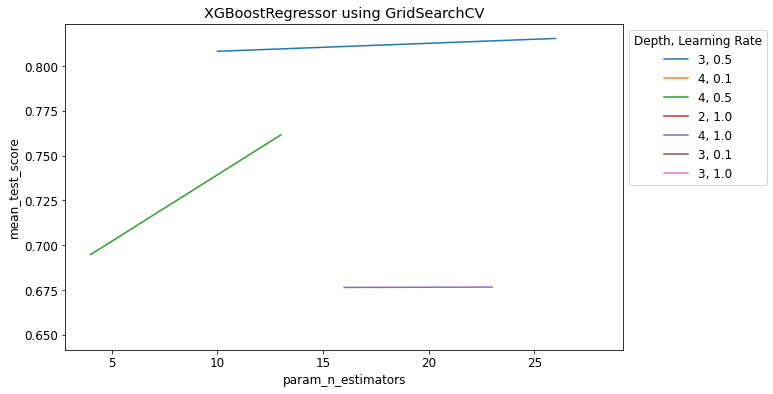

In [ ]:
# Lets try to improve the graph using a pdSeries for the hue parameter
hue = cv_results[["param_max_depth", "param_learning_rate"]].apply(
    lambda row: f"{row.param_max_depth}, {row.param_learning_rate}", axis=1)

plt.subplots(figsize=(10, 6))

# Plotting the final data
sns.lineplot(data=cv_results, x="param_n_estimators", y="mean_test_score", 
             hue=hue).set(title='XGBoostRegressor using GridSearchCV')
plt.legend(bbox_to_anchor=(1, 1), title='Depth, Learning Rate', title_fontsize=12)


### Lets start concluding the project Machine Learning for predicting the Bandgap of Semiconductors
- Boosting models perfom the best (CatBoost and XGBoost) with $R^2 > 0.94$
- The most important features for predicting the bandgap are the `lattice_a`, `cbm` and `vbm`
- Using RandomizedSearchCV or GridSearchCV is mostly useful for simple models (RandomForestRegressor)
-**biggest conclusion**: it is not necessary to run a full DFT simulation to predict the bandgap of a Ultrawide Bandgap (UWBG) Semiconductors, one can just use this model to know the bandgap (saves time, computer power...)


- still to improve:
  - more data! 
  - try an Ensemble model
  - extent analysis to other class of compounds
  - encode the object features ina different way (one hot encoding ...)


In [ ]:
dados2["y_preds_xgboost"] = y_preds_xgboost
dados2["y_preds_catboost"] = y_preds_catboost
dados2.head()

,material,A,B,C,cbm,vbm,bandgap_direct,lattice_a,lattice_b,lattice_c,lattice_alpha,lattice_beta,lattice_gamma,true_labels,pred_labels,material_reversed,y_preds_xgboost,y_preds_catboost
35,76,4,4,4,3.412784,1.998913,False,7.592095,7.597546,11.317734,111.177519,68.863766,100.560450,1.413871,2.010118,MgTlBr5,1.585958,1.635380
95,16,1,4,4,2.521759,0.984261,False,8.577981,8.540201,14.608898,122.768713,57.383927,123.927723,1.537498,2.752986,BaTlBr5,1.807168,2.156467
12,35,2,4,3,2.670963,-2.089296,True,5.212960,5.211415,8.438576,113.879620,66.108932,99.538760,4.760259,5.351245,BeInI5,4.447317,4.800870
71,92,5,3,4,3.124131,1.142105,False,7.857866,7.856972,12.119720,113.238619,66.795954,102.248036,1.982026,1.993955,SrInBr5,1.851146,2.078498
34,73,4,4,1,1.601263,0.040939,True,7.145060,7.068968,11.622900,116.480182,63.090629,113.556545,1.560324,2.395979,MgInCl5,2.227651,2.039103


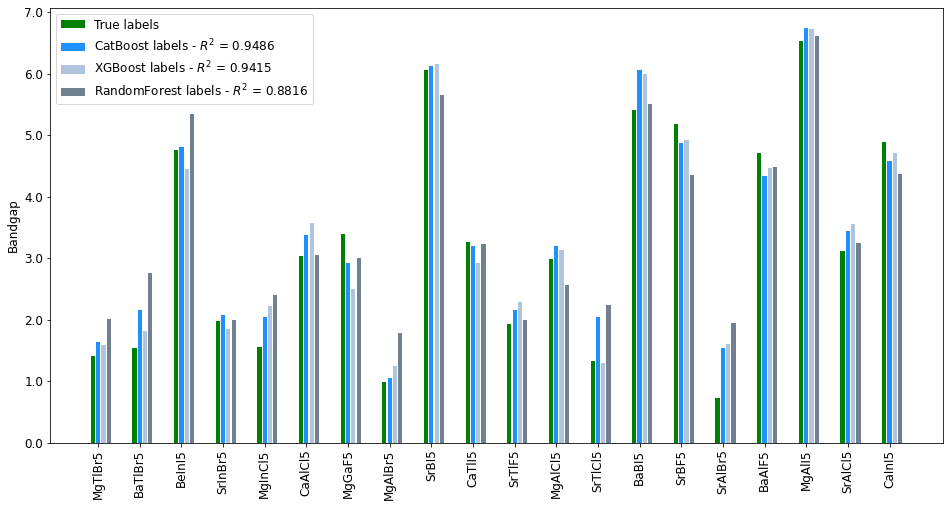

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

X_axis = np.linspace(1, 150, len(dados2['material_reversed']))

# Plotting the RandomForestRegressor best results (coming from the GridSearchCV)
plt.bar(X_axis-1, dados2['true_labels'], label="True labels", color="green")

plt.bar(X_axis, dados2['y_preds_catboost'], 
        color="dodgerblue",
        label="CatBoost labels - $R^2$ = {:.4f}".format(cat_boost.score(X_test, y_test)))

plt.bar(X_axis+1, dados2['y_preds_xgboost'], 
        color="lightsteelblue",
        label="XGBoost labels - $R^2$ = {:.4f}".format(xg_boost_ideal.score(X_test, y_test)))

plt.bar(X_axis+2, dados2['pred_labels'], 
        color="slategrey",
        label="RandomForest labels - $R^2$ = {:.4f}".format(ideal_model.score(X_test, y_test)))

plt.ylabel("Bandgap")
plt.legend()

formatter = matplotlib.ticker.StrMethodFormatter("{x:.1f}")
plt.gca().yaxis.set_major_formatter(formatter)

_ = plt.xticks(X_axis, dados2['material_reversed'], rotation=90)